In [1]:
"""
File: tng_images.py
Author: Matthew Ogden
Email: ogdenm12@gmail.com
Github: mbogden
Created: 2024-Apr-02

Description: 
    This code is designed to pull particle data from the IllustrisTNG Simulation Particles. 
    And visualize if a variety of ways for future use. 

References:  
- TNG50 Simulation Data
    - Nelson, D. et al. (2015). The Illustris Simulation: Public Data Release. Astronomy and Computing, 13, 12–37. https://doi.org/10.1016/j.ascom.2015.09.003
    - Nelson, D. et al. (2019). First results from the TNG50 simulation: Galactic outflows driven by supernovae and black hole feedback. Monthly Notices of the Royal Astronomical Society, 490(3), 3234–3261. https://doi.org/10.1093/mnras/stz2306
    - Pillepich, A. et al. (2019). First results from the TNG50 simulation: The evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Society, 490(3), 3196–3233. https://doi.org/10.1093/mnras/stz2338

Acknowledgements:    
- Sections of this code were written with the assistance of ChatGPT made by OpenAI.

"""


'\nFile: tng_images.py\nAuthor: Matthew Ogden\nEmail: ogdenm12@gmail.com\nGithub: mbogden\nCreated: 2024-Apr-02\n\nDescription: \n    This code is designed to pull particle data from the IllustrisTNG Simulation Particles. \n    And visualize if a variety of ways for future use. \n\nReferences:  \n- TNG50 Simulation Data\n    - Nelson, D. et al. (2015). The Illustris Simulation: Public Data Release. Astronomy and Computing, 13, 12–37. https://doi.org/10.1016/j.ascom.2015.09.003\n    - Nelson, D. et al. (2019). First results from the TNG50 simulation: Galactic outflows driven by supernovae and black hole feedback. Monthly Notices of the Royal Astronomical Society, 490(3), 3234–3261. https://doi.org/10.1093/mnras/stz2306\n    - Pillepich, A. et al. (2019). First results from the TNG50 simulation: The evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Society, 490(3), 3196–3233. https://doi.org/10.1093/mnras/stz2338\n\nAcknowledgements:    

In [2]:

# ================================ IMPORTS ================================ #
import gc, os, argparse, h5py
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec 
from sklearn.decomposition import PCA
import plotly.graph_objects as go



# Illustris TNG import
import illustris_python as il
import tng_functions as tf
import tng_particles as tp # particle_module

print("Imports Done")

# Global variables
SIM_DIR = '../sims.TNG/TNG50-1/output/'
# Set NumPy print options to reduce the precision to 3 decimal places
np.set_printoptions(precision=2)

# Am I currently writing this code?
buildEnv = True

Imports Done
Args: Defined
Imports Done


In [3]:
# ================================ INPUT ARGUMENTS ================================ #

# Define argument parser function 
def initParser():
    
    parser = argparse.ArgumentParser()
    
    # Simulation Arguments
    parser.add_argument( '-s', '--simDir', default = '/home/tnguser/sims.TNG/TNG50-1/output',  type=str, \
                        help="Base directory for a single simulation on the IllustrisTNG servers.")   
    
    parser.add_argument( '-n', '--simName', default = 'TNG50-1',  type=str, \
                        help="Name for the simulation being worked on.")    

    # Function arguments
    parser.add_argument( '-f', '--function', default = 'None', type=str, \
                        help="Unqiue functions this program can execute from command line.")
    
    parser.add_argument( '-d', '--dataDir', default = 'tng-data', type=str, \
                        help="Default location to store misc data files.")
    
    parser.add_argument('-ow', '--overwrite', action='store_true',
                        help="Overwrite output files? \
                        If false, will check if output file exists before beginning time-consuming tasks.")
    
    parser.add_argument( '-i', '--inputFile', type=str, \
                        help="Input file location.")
    
    parser.add_argument( '-o', '--outputFile', type=str, \
                        help="Output file location.")
    
    parser.add_argument( '-id', '--targetID', type=int, \
                        help="Misc ID value.  Different between functions.")
    
    
    return parser

parser = initParser()
script_args = parser.parse_args()
print("Args: Defined")

Args: Defined


In [4]:
# Specify columns for positions vs orientation transformations
pos_col = [ 'SubhaloPos', 'SubhaloCM' ]
angle_col = [ 'SubhaloVel','SubhaloSpin' ]
prefix = [ 'p', 's', 'pa', 'ps', 'sa', 'ss' ]

if buildEnv and True:
    
    m_loc = 'tng-data/moi_4-test-dynamics.pkl'
    assert os.path.exists( m_loc ), f'Target information file not found: {m4_loc}'
    print(f"Reading: {m_loc}")
    
    # Read potential tng targets file
    m_df = pd.read_pickle( m_loc )
    print( f"ALL MOI_4 Shape {m_df.shape}")
    print( f"Columns: {m_df.columns}" )
    
    # Print targets noted add moi-4
    m4_rows = m_df[ m_df['moi_4'] == True ]
    print( m4_rows['p_SubhaloIDRaw'] )
    
    # I noticed i forget to give pa, ps, sa, ss positions. They should be the same as p and s respectively.
    m_df['pa_SubhaloPos'] = m_df['p_SubhaloPos']
    m_df['ps_SubhaloPos'] = m_df['p_SubhaloPos']
    m_df['sa_SubhaloPos'] = m_df['s_SubhaloPos']
    m_df['ss_SubhaloPos'] = m_df['s_SubhaloPos']    
    
    pid = 56000000230959
    t_row = m_df[ m_df['p_SubhaloIDRaw'] == pid ].iloc[0]
    t_snap = t_row['snap']
    t_df = m_df[ m_df['moi_2'] == t_row['moi_2'] ]
    print( t_row )
    
    # Get clean df to prevent future errors.
    t_df = t_df[ t_df['pa_SubhaloCM'].notna() ]


Reading: tng-data/moi_4-test-dynamics.pkl
ALL MOI_4 Shape (102, 71)
Columns: Index(['moi_2', 'snap', 'merger_snap', 'p_moi_1', 's_moi_1', 'xy_projection',
       'p_face_projection', 's_face_projection', 'p_SubhaloID', 's_SubhaloID',
       'p_NextProgenitorID', 's_NextProgenitorID', 'p_MainLeafProgenitorID',
       's_MainLeafProgenitorID', 'p_FirstProgenitorID', 's_FirstProgenitorID',
       'p_SubhaloGrNr', 's_SubhaloGrNr', 'p_SubhaloIDRaw', 's_SubhaloIDRaw',
       'p_SubhaloMass', 's_SubhaloMass', 'p_RootDescendantID',
       's_RootDescendantID', 'p_SnapNum', 's_SnapNum', 'p_DescendantID',
       's_DescendantID', 'p_SubhaloPos', 's_SubhaloPos', 'p_SubhaloVel',
       's_SubhaloVel', 'p_SubhaloSpin', 's_SubhaloSpin',
       'p_SubhaloHalfmassRad', 's_SubhaloHalfmassRad', 'p_SubhaloCM',
       's_SubhaloCM', 'moi_4', 'p_inclination', 'p_azimuthal', 's_inclination',
       's_azimuthal', 'pa_SubhaloMass', 'pa_SubhaloCM', 'pa_SubhaloVel',
       'pa_SubhaloSpin', 'pa_SubhaloHalfmass

---
# 2D Histogram of Particles

The simpliest way to create create my own image of the interaction is to read the particles and binning them in a 2D histogram.

In [5]:
def get_plot_pts( t_row, t_df, save_file =False, dev_print=False ):
    
    if dev_print: print("Getting Particles for Plotting")
    
    # Get info for galaxies to pull particles for
    _, pid = tf.deconstruct_subhalo_id_raw( t_row['p_SubhaloIDRaw']  )
    _, sid = tf.deconstruct_subhalo_id_raw( t_row['s_SubhaloIDRaw']  )
    snap = t_row['snap']    
    
    if dev_print:  
        print( snap, pid, sid )
    
    # Pull particles
    if dev_print:  tf.tabprint(f"Getting Subhalo Particles: {pid}")
    p_pts = il.snapshot.loadSubhalo('/home/tnguser/sims.TNG/TNG50-1/output', 
                            snap, pid, 4, fields=['Coordinates', 'Velocities', 'ParticleIDs'])
    
    if dev_print:  tf.tabprint(f"Getting Subhalo Particles: {sid}")
    s_pts = il.snapshot.loadSubhalo('/home/tnguser/sims.TNG/TNG50-1/output', 
                            snap, sid, 4, fields=['Coordinates', 'Velocities', 'ParticleIDs'])
    
    # Store particles in standardized format       
    id1 = np.hstack([p_pts['ParticleIDs'], s_pts['ParticleIDs']]) 
    pos = np.vstack([p_pts['Coordinates'], s_pts['Coordinates']])
    vel = np.vstack([p_pts['Velocities'],  s_pts['Velocities']])
    
    pn = p_pts['Coordinates'].shape[0]
    sn = s_pts['Coordinates'].shape[0]
    gid = np.hstack([np.zeros(pn), np.ones(sn)]).reshape(-1,1) 
    
    # Load my historical labels for galaxies
    if dev_print:  tf.tabprint(f"Getting Historical Labels: ")
    id2, label_ar = tp.get_hist_labels_dict( t_df, snap, part_type = 'star', save_file=save_file )

    if dev_print:  tf.tabprint(f"Conjoining Labels w/ Particles: ")
    # Sort id2 and get sorted indices
    sorted_idx = np.argsort(id2)
    sorted_id2 = id2[sorted_idx]

    # Get indices of id1 in sorted_id2
    sorted_indices = np.searchsorted(sorted_id2, id1)

    # Map back to the original indices
    indices = sorted_idx[sorted_indices]
    
    # Finally, get labels
    hid = label_ar[indices]  
    hid = label_ar.reshape((-1,1))

    if dev_print: print( 'Pts: ', pos.shape, vel.shape, gid.shape, hid.shape )
    pts = np.hstack( [ pos, vel, gid, hid ] )
    
    return pts

if buildEnv and True:    
    pts = get_plot_pts( t_row, t_df, save_file=True, dev_print=True )
    # pts = get_plot_pts( t_row, t_df, save_file=False, dev_print=True )
    print('Pts!:', pts.shape, '\n' )
    print(pts)

Getting Particles for Plotting
56 230959 230960
	 - Getting Subhalo Particles: 230959
	 - Getting Subhalo Particles: 230960
	 - Getting Historical Labels: 
Calculating Historical Ownership (via Dictionary): 67000000258162
	 - Files already created
	 - Conjoining Labels w/ Particles: 
Pts:  (2660971, 3) (2660971, 3) (2660971, 1) (2660971, 1)
Pts!: (2660971, 8) 

[[ 2.35e+04  5.84e+03  3.19e+04 ... -1.80e+01  0.00e+00  0.00e+00]
 [ 2.35e+04  5.84e+03  3.19e+04 ... -6.52e+00  0.00e+00  0.00e+00]
 [ 2.35e+04  5.84e+03  3.19e+04 ...  2.62e+00  0.00e+00  0.00e+00]
 ...
 [ 2.35e+04  5.85e+03  3.19e+04 ... -2.13e+02  1.00e+00  1.00e+00]
 [ 2.35e+04  5.85e+03  3.19e+04 ... -3.26e+02  1.00e+00  1.00e+00]
 [ 2.35e+04  5.85e+03  3.19e+04 ... -1.63e+02  1.00e+00  1.00e+00]]


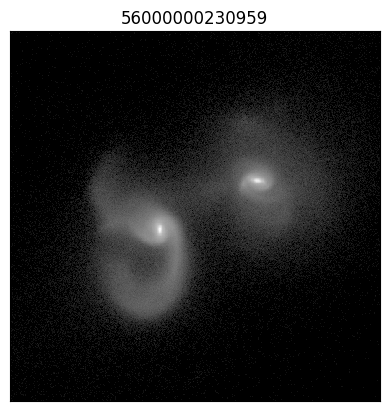

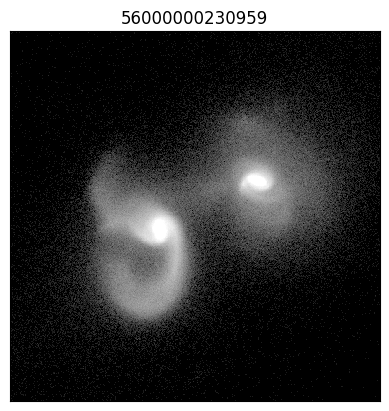

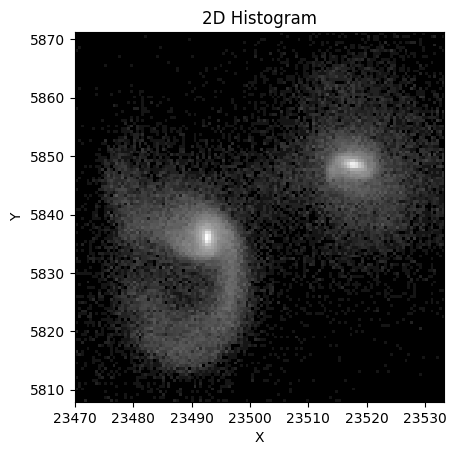

In [6]:
def xy_histogram( xy_data, ax=None,  title="2D Histogram", \
                  std_dev=3, bins=256, cmap='gray', \
                  log_scale=True, dim_inner = -1, \
                  show_labels=False, plotting=True):
    """
    Plots a 2D histogram on a given axis with x and y limits set to n standard deviations.

    Args:
    ax (matplotlib.axes.Axes or None): The axis to plot on. If None, a new figure and axis will be created.
    xy_data (np.ndarray): An N x 2 array of xy coordinates.
    title (str): Title of the subplot.
    std_dev (float): Number of standard deviations to set axis limits.
    bins (int): Number of bins along each axis in the histogram.
    cmap (str): Colormap for the histogram.
    log_scale (bool): Whether to apply logarithmic scaling to the histogram.
    """
    if xy_data is None:
        raise ValueError("xy_data cannot be None")

    # If ax is None, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    # Calculate the mean and standard deviation
    mean_xy = np.mean(xy_data[:, 0:2], axis=0)
    std_xy = np.std(xy_data[:, 0:2], axis=0)

    # Determine the maximum range to use for both axes
    max_range = np.max(std_xy) * std_dev

    # Set axis limits to be the same for both x and y
    xlim = (mean_xy[0] - max_range, mean_xy[0] + max_range)
    ylim = (mean_xy[1] - max_range, mean_xy[1] + max_range)

    # Create the histogram
    h, xedges, yedges, image = ax.hist2d(xy_data[:, 0], xy_data[:, 1], bins=bins, range=[xlim, ylim], cmap=cmap)
    
    # 
    if dim_inner != -1:
        
        # Calculate the mean and standard deviation of the histogram bin counts
        mean_bin_count = np.mean(h)
        std_bin_count = np.std(h)

        # Set a threshold to cap the brightest regions
        threshold = mean_bin_count + dim_inner * std_bin_count  # You can adjust this multiplier

        # Apply the threshold to cap the values in the histogram
        h[h > threshold] = threshold  # Cap all bin counts above the threshold

    
    
    # Apply log1p to enhance visibility of low count regions
    if log_scale:
        h = np.log1p(h)  

    # Clear the axis and plot with modified histogram data
    ax.clear()
    image2 = ax.imshow(h.T, interpolation='nearest', origin='lower', aspect='auto',
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                      cmap=cmap)
    
    # Set titles and labels
    ax.set_title(title)
    
    if show_labels:
        # Add axis labels and ticks (they are no longer removed)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    else:   
        # Remove the axis labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    # If ax was None, display the plot
    if ax is None:
        plt.show()
    
    return

if buildEnv:
    t_img = xy_histogram( pts, bins = 512, log_scale = True, std_dev = 3, title=f"{t_row['p_SubhaloIDRaw']}", )
    t_img = xy_histogram( pts, bins = 512, log_scale = True, std_dev = 3, title=f"{t_row['p_SubhaloIDRaw']}", dim_inner = 3 )

    # Let's grab a subsample of particles to visualize transformations
    n = 100000
    indices = np.random.choice( pts.shape[0], n, replace=False)
    pt0 = pts[indices]
    
    xy_histogram( pt0, bins=128, show_labels=True, std_dev=2 )
    

---
# Reference Frame Transformation

Something I would like to do is standardize a reference frame (RF) for all our targets.  As of right now, they're all traveling in whatever random direction at any ole orientation within the simulation.  Therefore, I decided I'd create a standardized one.  The following are the steps I'm taking to standardize it.

1) Translate: Calculate the Comoving Center of Mass, set its position and velocity to zero.
2) Rotate Z-axis: Set galaxy centers to be on the XZ-plane, primary on negative x-axis, secondary for positive.
3) Rotate Y-axis: Rotate galaxy centers until they're on the XY-plane, and thus on the X-axis. 
4) Rotate X-axis: Rotate so orbital path of galaxy centers over time are on XY-plane. 


### Step 1: Translate position and velocity to COM Frame of Reference


MOD 1 Transforms:
POS Mat:
 [[ 1.00e+00  0.00e+00  0.00e+00 -2.35e+04]
 [ 0.00e+00  1.00e+00  0.00e+00 -5.84e+03]
 [ 0.00e+00  0.00e+00  1.00e+00 -3.19e+04]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
VEL Mat:
 [[  1.     0.     0.   222.33]
 [  0.     1.     0.    71.73]
 [  0.     0.     1.    32.58]
 [  0.     0.     0.     1.  ]] 



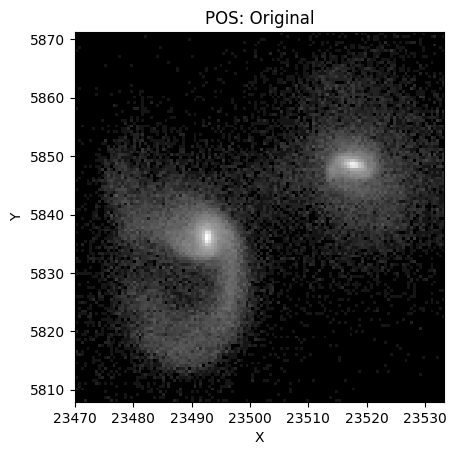

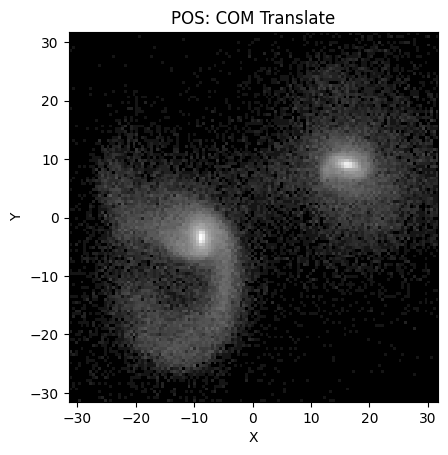

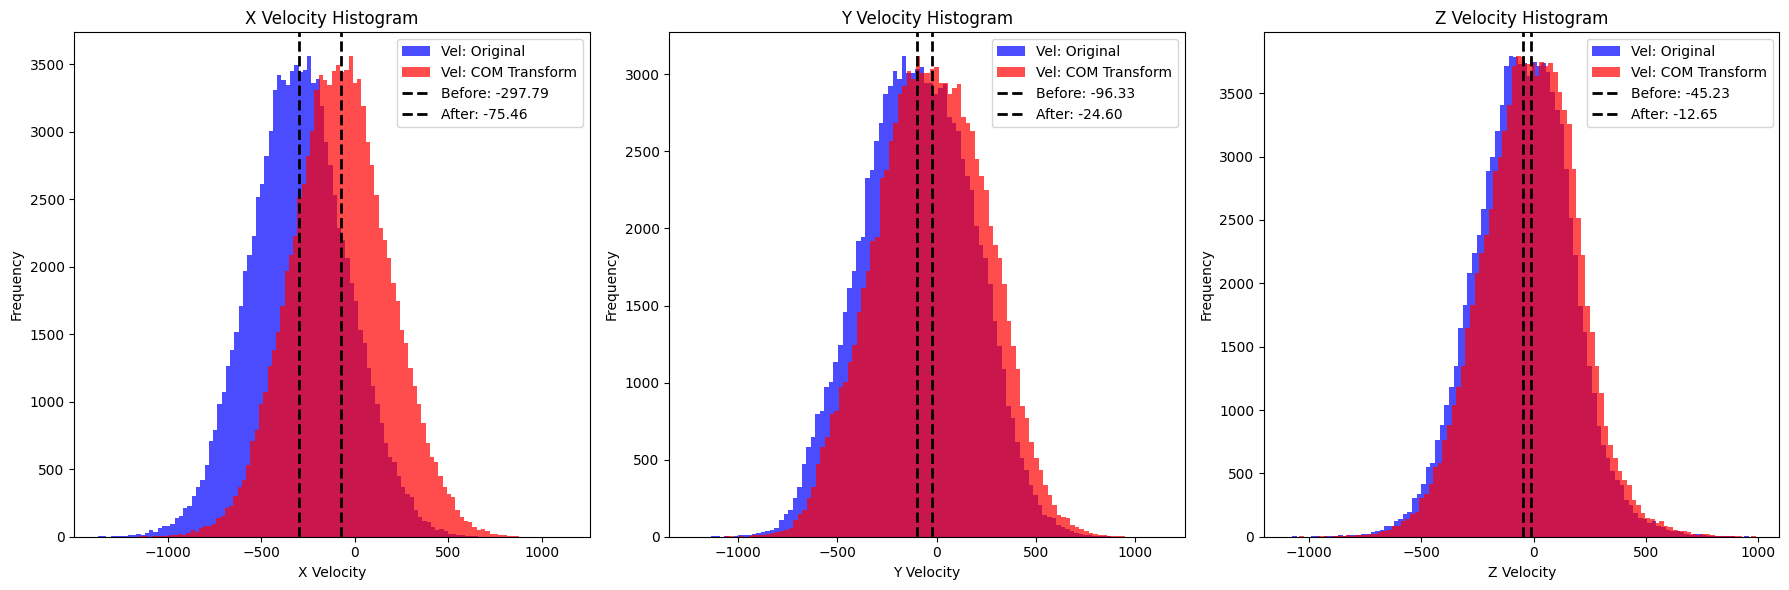

In [7]:
def pt_apply_transformation(points_in, matrix, vel_matrix=None):
    """
    Apply a transformation matrix to a list of 3D points or a single 3D point.
    Supports both 3x3 rotation matrices and 4x4 transformation matrices.
    Optionally applies a velocity transformation to columns 3, 4, and 5.

    Parameters:
    -----------
    - points_in: (numpy.ndarray) An NxM array of points (where M >= 3).
    - matrix: (numpy.ndarray) A 3x3 rotation matrix or a 4x4 transformation matrix.
    - vel_matrix: (numpy.ndarray, optional) A 3x3 or 4x4 matrix for velocity transformation.
                 If provided, it will be applied to columns 3, 4, and 5.

    Returns:
    --------
    - transformed_points: (numpy.ndarray) The NxM array of transformed points.
    """
    
    # Copy the input points to avoid modifying the original array
    points = points_in.copy()

    # Handle single point case (if points_in is 1D with at least 3 elements)
    if points.ndim == 1:
        if points.shape[0] < 3:
            raise ValueError("Point must have at least 3 elements.")
        points = points.reshape(1, -1)  # Convert to 2D for consistent processing
        single_point = True
    else:
        single_point = False

    # Transform the first 3 columns
    if matrix.shape == (3, 3):
        # Case 1: Apply 3x3 rotation matrix
        points[:, :3] = np.dot(points[:, :3], matrix.T)

    elif matrix.shape == (4, 4):
        # Case 2: Apply 4x4 transformation matrix (rotation + translation)
        n_points = points.shape[0]
        homogeneous_points = np.ones((n_points, 4))
        homogeneous_points[:, :3] = points[:, :3]  # Use only first 3 columns
        transformed_homogeneous_points = np.dot(homogeneous_points, matrix.T)
        points[:, :3] = transformed_homogeneous_points[:, :3]  # Update original points

    else:
        raise ValueError("The transformation matrix must be either 3x3 or 4x4.")

    # Apply velocity transformation if vel_matrix is provided
    if vel_matrix is not None:
        if vel_matrix.shape == (3, 3):
            # Apply 3x3 rotation matrix to velocity columns
            points[:, 3:6] = np.dot(points[:, 3:6], vel_matrix.T)

        elif vel_matrix.shape == (4, 4):
            # Apply 4x4 transformation matrix to velocity columns
            homogeneous_vel = np.ones((n_points, 4))
            homogeneous_vel[:, :3] = points[:, 3:6]
            transformed_homogeneous_vel = np.dot(homogeneous_vel, vel_matrix.T)
            points[:, 3:6] = transformed_homogeneous_vel[:, :3]

        else:
            raise ValueError("The velocity matrix must be either 3x3 or 4x4.")

    # If it was a single point, return it as a 1D array
    if single_point:
        return points[0]

    return points



def get_mod1_transform(t_row, dev_print=False):
    """
    This function computes the center of mass (COM) position and velocity for two galaxies
    and returns both the COM position and velocity, along with transformation matrices
    to shift the positions and velocities to a COM-centered reference frame.
    
    Parameters:
    -----------
    t_row : (pandas.Series) A row from a DataFrame containing 
            dynamic collision information for two galaxies.
    
    Returns:
    --------
    pos_com : numpy.ndarray
        The position vector of the center of mass.
    vel_com : numpy.ndarray
        The velocity vector of the center of mass.
    translation_matrix : numpy.ndarray
        A 4x4 transformation matrix for translating positions 
        so that the COM is at the origin.
    """
    
    # Extract positions, velocities, and masses
    p1 = t_row['ps_SubhaloCM'] 
    v1 = t_row['ps_SubhaloVel']
    m1 = t_row['ps_SubhaloMass'] 
    
    p2 = t_row['ss_SubhaloCM']
    v2 = t_row['ss_SubhaloVel']
    m2 = t_row['ss_SubhaloMass'] 
    assert not np.isnan( np.stack( [ p1, v1, p2, v2 ] )).any(), "Invalid  Number"
        
    # Compute the center of mass position and velocity
    pos_com = (m1 * p1 + m2 * p2) / (m1 + m2)
    vel_com = (m1 * v1 + m2 * v2) / (m1 + m2)

    # Create translation matrix for position transformation (4x4)
    pos_translation_matrix = np.eye(4)  # Start with identity matrix
    pos_translation_matrix[:3, 3] = -pos_com  # Set translation part (negative COM position)

    # Create translation matrix for velocity transformation (4x4)
    vel_translation_matrix = np.eye(4)  # Start with identity matrix
    vel_translation_matrix[:3, 3] = -vel_com  # Set translation part (negative COM velocity)
    
    if dev_print:
        print("\nMOD 1 Transforms:")
        print("POS Mat:\n", pos_translation_matrix)
        print("VEL Mat:\n", vel_translation_matrix, '\n')

    return pos_translation_matrix, vel_translation_matrix

if buildEnv:
    
    # Transform particles
    m1_pos, m1_vel = get_mod1_transform( t_row, dev_print=True )
    pt1 = pt0.copy()
    pt1 = pt_apply_transformation( pt0, m1_pos, m1_vel )
    
    # Plot positions for verification
    xy_histogram( pt0, bins=128, show_labels=True, std_dev=2, title='POS: Original' )
    xy_histogram( pt1, bins=128, show_labels=True, std_dev=2, title='POS: COM Translate' )
    
    # Bin velocites for verification
    
    # Create a 1x3 grid of subplots for X, Y, and Z velocities
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Titles for the velocity components
    velocity_titles = ['X Velocity', 'Y Velocity', 'Z Velocity']
    bins = 100
    
    # Loop through the velocity components (3rd to 5th columns in the array)
    for i in range(3):
        # Plot pt0 velocities (before transformation) and pt1 velocities (after transformation)
        axs[i].hist(pt0[:, 3 + i], bins=bins, color='blue', alpha=0.7, label='Vel: Original')
        axs[i].hist(pt1[:, 3 + i], bins=bins, color='red', alpha=0.7, label='Vel: COM Transform')
        
        # Compute and plot the mean value for pt0 and pt1
        mean_pt0 = np.mean(pt0[:, 3 + i])
        mean_pt1 = np.mean(pt1[:, 3 + i])
        axs[i].axvline(mean_pt0, color='k', linestyle='dashed', linewidth=2, label=f'Before: {mean_pt0:.2f}')
        axs[i].axvline(mean_pt1, color='k', linestyle='dashed', linewidth=2, label=f'After: {mean_pt1:.2f}')
        
        # Set title, labels, and legend
        axs[i].set_title(f'{velocity_titles[i]} Histogram')
        axs[i].set_xlabel(f'{velocity_titles[i]}')
        axs[i].set_ylabel('Frequency')
        axs[i].legend(loc='upper right')
    
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

COM Transform Done


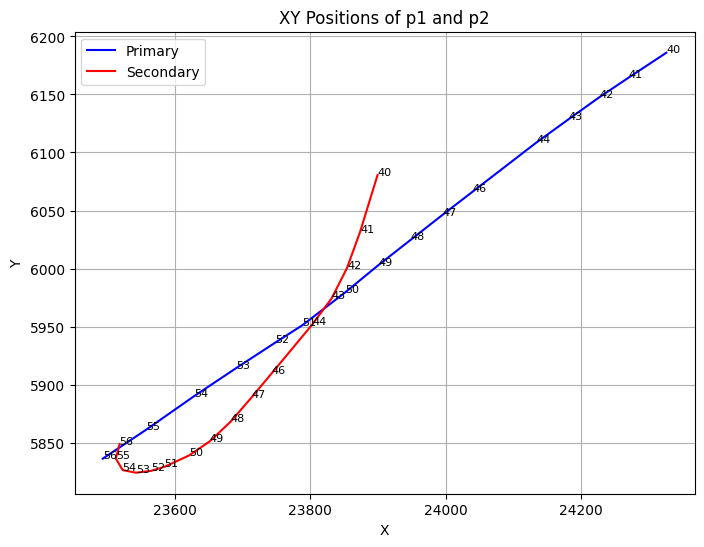

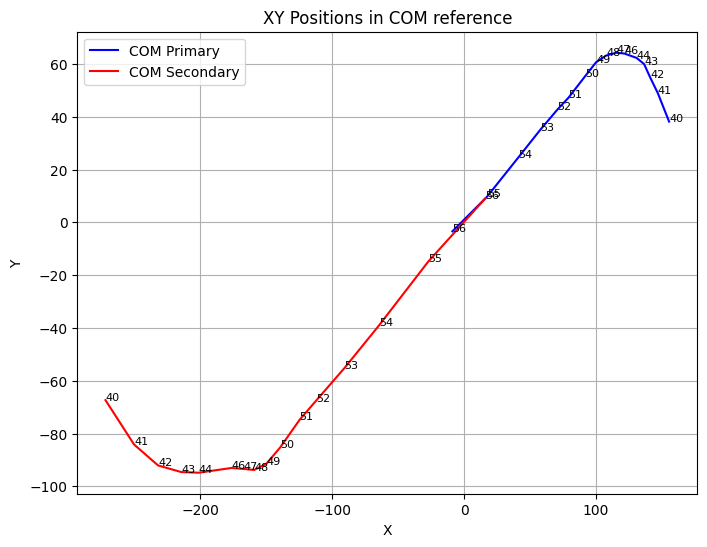

In [8]:
def mod1_df_transform( t_df ):
    
    mod1_df_list = []
    
    # Iterate over every snapshot to apply COM transform
    for i, row in t_df.iterrows():
        try:
            # Get the COM position, velocity, and transformation matrices
            com_pos_transform, com_vel_transform = get_mod1_transform(row,)
            
            # Create a new series with the transformed data
            new_data = pd.Series({
                'p_SubhaloIDRaw': row['p_SubhaloIDRaw'],
                'mod1_pos_transform': com_pos_transform,
                'mod1_vel_transform': com_vel_transform
            })
            
            # Loop through all dynamics for modification
            for p in prefix:
                
                # Position changes
                for c in pos_col:
                        new_data[f'{p}_{c}_mod1'] = pt_apply_transformation( row[f'{p}_{c}'], com_pos_transform)
                                
                # velocity change
                new_data[f'{p}_SubhaloVel_mod1'] = pt_apply_transformation( row[f'{p}_SubhaloVel'], com_vel_transform )
                
                # Spine stays the same
                new_data[f'{p}_SubhaloSpin_mod1'] = row[f'{p}_SubhaloSpin']

            # Append the new series to the current row of the DataFrame
            mod1_df_list.append(new_data)

            # print("Success")
            
        except Exception as e:
            print(f"Failed on index {i} with error: {e}")
            continue
    
    # Print the final dataframe for verification
    mod1_df = pd.DataFrame( mod1_df_list )
    new_df = t_df.merge(mod1_df, on = 'p_SubhaloIDRaw')
        
    return new_df

if buildEnv:
    t1_df = mod1_df_transform( t_df )  # transform 1
    t1_row = t1_df[t1_df['snap'] == t_snap].iloc[0]
    
    # print( t1_df['mod1_vel_transform'] )
    
    # pts1 = com
    print("COM Transform Done")
    # Plot results   
    snaps = np.stack( t1_df[t1_df['s_SubhaloPos_mod1'].notna()]['snap'].values)
    
    p0 = np.stack(t1_df[t1_df['p_SubhaloPos'].notna()]['p_SubhaloPos'].values)
    s0 =  np.stack(t1_df[t1_df['s_SubhaloPos'].notna()]['s_SubhaloPos'].values)
    p1 =  np.stack(t1_df[t1_df['p_SubhaloPos_mod1'].notna()]['p_SubhaloPos_mod1'].values)
    s1 =  np.stack(t1_df[t1_df['s_SubhaloPos_mod1'].notna()]['s_SubhaloPos_mod1'].values)
 
    # print( p1.shape, snaps.shape )

    # Plot the xy values of p1 and p2
    plt.figure(figsize=(8, 6))
    plt.plot(p0[:, 0], p0[:, 1], label='Primary', c='blue')
    plt.plot(s0[:, 0], s0[:, 1], label='Secondary', c='red')
    for i, snap in enumerate(snaps):
        plt.text(p0[i, 0], p0[i, 1], str(snap), fontsize=8, color='k')
        plt.text(s0[i, 0], s0[i, 1], str(snap), fontsize=8, color='k')
        
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('XY Positions of p1 and p2')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the xy values of mp1 and ms1 (after modification)
    plt.figure(figsize=(8, 6))
    plt.plot(p1[:, 0], p1[:, 1], label='COM Primary', c='blue')
    plt.plot(s1[:, 0], s1[:, 1], label='COM Secondary', c='red')
    for i, snap in enumerate(snaps):
        plt.text(p1[i, 0], p1[i, 1], str(snap), fontsize=8, color='k')
        plt.text(s1[i, 0], s1[i, 1], str(snap), fontsize=8, color='k')
        
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('XY Positions in COM reference')
    plt.legend()
    plt.grid(True)
    plt.show()

Excellent!  The positions have changed and the velocity are averaged around zero.  This make sense because the galaxies appeared to be traveling in an negative xy direction before the COM transform.

NOTE: This is an average of a subsample of stars, thus the overall average for the entire galaxy may be off. 

---

### Step 2) Rotate about Z-Axis so galaxies centers are on XZ-plane, with primary to left.

In [9]:
def get_rot_matrix( theta ):
    # Construct rotation matrix
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rot_matrix = np.array([
        [cos_theta, -sin_theta, 0, 0],
        [sin_theta,  cos_theta, 0, 0],
        [0,          0,         1, 0],
        [0,          0,         0, 1]
    ])
    
    return rot_matrix


def get_mod2_transform(t_row, dev_print=False):
    """
    Rotates the galaxy positions:
    1. Rotate around the z-axis to align the 'mod1' y-positions with the xz-plane.
    
    Parameters:
    -----------
    t_row : (pandas.Series) A row from the DataFrame containing the galaxy centers and velocities.
    
    Returns:
    --------
    final_rotation_matrix : numpy.ndarray
        The final composite rotation matrix used for the transformation.
    """
    
    # Extract Mod1 positions
    p = t_row['p_SubhaloPos_mod1'] # primary
    s = t_row['s_SubhaloPos_mod1'] # secondary
    pv = t_row['p_SubhaloVel_mod1']
    sv = t_row['s_SubhaloVel_mod1']
    
    if dev_print: print( p, s )
        
    # Step 1: Rotate around origin so primary point have y=0.
    theta = -np.arctan2( p[1], p[0] ) + np.pi
    rot1_mat = get_rot_matrix( theta )
    
    # Convert p1 and s1 to homogeneous coordinates (4D vectors)
    p_homogeneous = np.append(p, 1)
    s_homogeneous = np.append(s, 1)
    
    # Rotate points
    p_rotated = np.dot( rot1_mat, p_homogeneous,  )
    s_rotated = np.dot( rot1_mat, s_homogeneous,  )
    if dev_print: print(p_rotated, s_rotated)
    
    # Step 2: Translate p1 to the origin
    translate_to_origin = np.eye(4)
    translate_to_origin[:3, 3] = -p_rotated[:3]  # Translation to origin
    
    # Apply the translation to both p1 and s1
    p_translated = np.dot(translate_to_origin, p_rotated)
    s_translated = np.dot(translate_to_origin, s_rotated)
    if dev_print: print( p_translated, s_translated)
    
    # Step 3: Rotate so secondary is also on xz-plane (y=0)
    theta2 = -np.arctan2( s_translated[1], s_translated[0] )
    rot2_mat = get_rot_matrix( theta2 )
    
    # Rotate points
    p_rotated_2 = np.dot( rot2_mat, p_translated,  )
    s_rotated_2 = np.dot( rot2_mat, s_translated,  )
    if dev_print: print( p_rotated_2, s_rotated_2 )
    
    # Step 4: Translate p1 back to it's position on xz-plane
    translate_back = np.eye(4)
    translate_back[:3, 3] = p_rotated[:3]  # Translation to origin
    
    # Apply the translation to both p1 and s1
    p_final = np.dot(translate_back, p_rotated_2)
    s_final = np.dot(translate_back, s_rotated_2)
    if dev_print: print( p_final, s_final)
    
    # Combine all the matrices into one for convenience
    mod2_mat_pos = rot1_mat
    for mat in [ translate_to_origin, rot2_mat, translate_back]:
        mod2_mat_pos = np.dot( mat, mod2_mat_pos,)
    if dev_print: 
        print( np.dot( mod2_mat_pos, p_homogeneous ), \
              np.dot( mod2_mat_pos, s_homogeneous ) )
        
    # Create a seperate matrix for just rotating velocities
    mod2_mat_vel = np.dot( rot2_mat, rot1_mat )
    
    # Apply the rotation to velocities (note: no homogeneous component for velocities)
    pv_rotated = pt_apply_transformation( pv, mod2_mat_vel )
    sv_rotated = pt_apply_transformation( sv, mod2_mat_vel )
    
    # Verify the direction are different but the total length is the same
    if dev_print:
        # Calculate and print magnitudes and vectors before rotation
        pv_magnitude_before = np.linalg.norm(pv)
        sv_magnitude_before = np.linalg.norm(sv)
        # Calculate and print magnitudes and vectors after rotation
        pv_magnitude_after = np.linalg.norm(pv_rotated)
        sv_magnitude_after = np.linalg.norm(sv_rotated)
        
        print(f"Primary before: {pv} (magnitude: {pv_magnitude_before:.3f})\n"
              f"Primary after : {pv_rotated} (magnitude: {pv_magnitude_after:.3f})\n"
              f"Secondary before: {sv} (magnitude: {sv_magnitude_before:.3f})\n"
              f"Secondary  after: {sv_rotated} (magnitude: {sv_magnitude_after:.3f})\n"
            )
        print("\nMOD 2 Transforms")
        print("POS Mat:\n", mod2_mat_pos)
        print("VEL Mat:\n", mod2_mat_vel)

    return mod2_mat_pos, mod2_mat_vel
    
if buildEnv:
    get_mod2_transform(t1_row, dev_print=True)

[-8.89 -3.41  1.97] [16.09  9.08 -4.04]
[-9.52e+00 -3.11e-07  1.97e+00  1.00e+00] [18.27  2.72 -4.04  1.  ]
[0. 0. 0. 1.] [27.79  2.72 -6.01  1.  ]
[0. 0. 0. 1.] [ 2.79e+01 -8.88e-16 -6.01e+00  1.00e+00]
[-9.52e+00 -3.11e-07  1.97e+00  1.00e+00] [ 1.84e+01 -3.11e-07 -4.04e+00  1.00e+00]
[-9.52e+00 -3.11e-07  1.97e+00  1.00e+00] [ 1.84e+01 -3.11e-07 -4.04e+00  1.00e+00]
Primary before: [15.5  12.9  15.16] (magnitude: 25.235)
Primary after : [19.64  4.61 15.16] (magnitude: 25.235)
Secondary before: [ 64.36  43.94 -22.15] (magnitude: 81.013)
Secondary  after: [ 77.21  10.52 -22.15] (magnitude: 81.013)


MOD 2 Transforms
POS Mat:
 [[ 0.89  0.45  0.   -0.05]
 [-0.45  0.89  0.   -0.93]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
VEL Mat:
 [[ 0.89  0.45  0.    0.  ]
 [-0.45  0.89  0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]


Target Snap 56


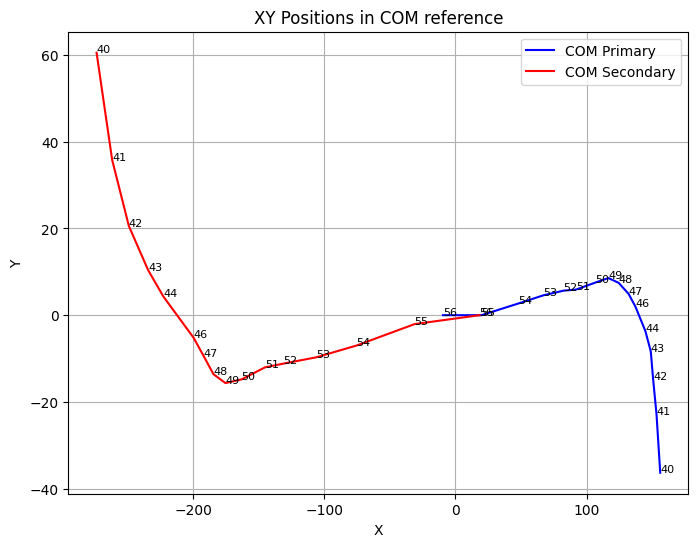

In [10]:
def mod2_df_transform( t_df ):
        
    mod2_df_list = []
    
    # Iterate over every snapshot to apply COM transform
    for i, row in t_df.iterrows():
        try:
            # Get the COM position, velocity, and transformation matrix
            mod2_pos, mod2_vel = get_mod2_transform(row)
            
            # Create a new series with the transformed data
            new_data = pd.Series({
                'p_SubhaloIDRaw':    row['p_SubhaloIDRaw'],
                'mod2_pos_transform': mod2_pos,
                'mod2_vel_transform': mod2_vel,
            })
            
            # Loop through all dynamics for modification
            for p in prefix:
                # Position based vectors
                for c in pos_col:
                        new_data[f'{p}_{c}_mod2'] = pt_apply_transformation( row[f'{p}_{c}_mod1'], mod2_pos )
                                
                # Orientation vectors
                for c in angle_col:
                        new_data[f'{p}_{c}_mod2'] = pt_apply_transformation( row[f'{p}_{c}_mod1'], mod2_vel )

            # Append the new series to the current row of the DataFrame
            mod2_df_list.append(new_data)

            # print("Success")
            
        except Exception as e:
            print(f"Failed on index {i} with error: {e}")
            continue
    
    # Print the final dataframe for verification
    mod2_df = pd.DataFrame( mod2_df_list )
    new_df = t_df.merge(mod2_df, on = 'p_SubhaloIDRaw')
        
    return new_df
    
if buildEnv:
    t_snap = t_row['snap']
    t2_df = mod2_df_transform( t1_df )
    t2_row = t2_df[ t2_df['snap'] == t_snap ].iloc[0]
    
    # Plot results   
    snaps = np.stack( t2_df[t2_df['s_SubhaloPos_mod1'].notna()]['snap'].values)
    p1 =  np.stack(t2_df['p_SubhaloPos_mod1'].values)
    s1 =  np.stack(t2_df['s_SubhaloPos_mod1'].values)
    print("Target Snap", t_snap)
    mod2_pos_transform = t2_row['mod2_pos_transform']
    
    p1 = pt_apply_transformation( p1, mod2_pos_transform )
    s1 = pt_apply_transformation( s1, mod2_pos_transform )
 
    # print( p1.shape, snaps.shape )
    # Plot the xy values of p1 and s1 (after modification)
    plt.figure(figsize=(8, 6))
    plt.plot(p1[:, 0], p1[:, 1], label='COM Primary', c='blue')
    plt.plot(s1[:, 0], s1[:, 1], label='COM Secondary', c='red')
    for i, snap in enumerate(snaps):
        plt.text(p1[i, 0], p1[i, 1], str(snap), fontsize=8, color='k')
        plt.text(s1[i, 0], s1[i, 1], str(snap), fontsize=8, color='k')
        
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('XY Positions in COM reference')
    plt.legend()
    plt.grid(True)
    plt.show()

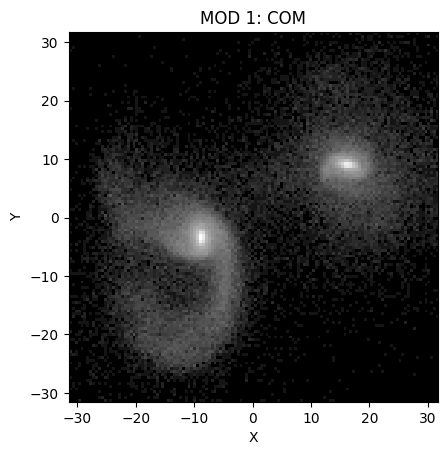

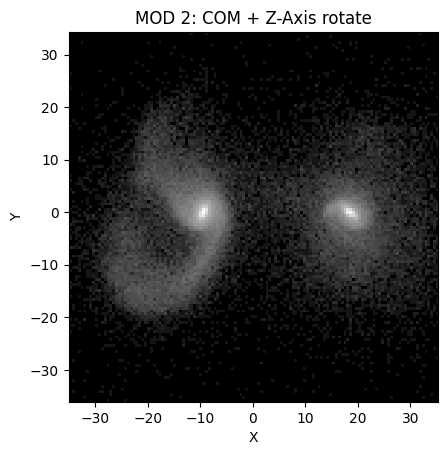

In [11]:
if buildEnv:
    
    pt2 = pt_apply_transformation( pt1[:,:3], mod2_pos_transform )
    
    pt2 = pt1.copy()
    pt2[:,0:3] = pt_apply_transformation( pt1[:,0:3], t2_row['mod2_pos_transform'] )
    pt2[:,3:6] =  pt_apply_transformation( pt1[:,3:6], t2_row['mod2_vel_transform'] )
    
    # Plot positions for verification
    xy_histogram( pt1, bins=128, show_labels=True, std_dev=2, title='MOD 1: COM' )
    xy_histogram( pt2, bins=128, show_labels=True, std_dev=2, title='MOD 2: COM + Z-Axis rotate' )


In [12]:
def get_rot_matrix_y(theta):
    """
    Construct rotation matrix around the y-axis.
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rot_matrix = np.array([
        [cos_theta,  0, sin_theta, 0],
        [0,          1, 0,         0],
        [-sin_theta, 0, cos_theta, 0],
        [0,          0, 0,         1]
    ])
    return rot_matrix

def get_mod3_transform(t_row, dev_print=False):
    """
    Rotates the galaxy positions:
    1. Rotate around the y-axis to align the 'mod2' z-positions with the xz-plane (z = 0).
    
    Parameters:
    -----------
    t_row : (pandas.Series) A row from the DataFrame containing the galaxy centers and velocities.
    
    Returns:
    --------
    final_rotation_matrix : numpy.ndarray
        The final composite rotation matrix used for the transformation.
    """
    
    # Extract Mod2 positions and velocities
    p = t_row['p_SubhaloPos_mod2']  # primary
    s = t_row['s_SubhaloPos_mod2']  # secondary
    pv = t_row['p_SubhaloVel_mod2']
    sv = t_row['s_SubhaloVel_mod2']
    
    if dev_print: print('Start:', p, s)
        
    # Step 1: Rotate around origin so primary point has z = 0.
    theta = np.arctan2(p[2], p[0])  # Rotate to align z to 0
    rot1_mat = get_rot_matrix_y(theta)
    
    # Convert p and s to homogeneous coordinates (4D vectors)
    p_homogeneous = np.append(p, 1)
    s_homogeneous = np.append(s, 1)
    
    # Rotate points
    p_rotated = np.dot(rot1_mat, p_homogeneous)
    s_rotated = np.dot(rot1_mat, s_homogeneous)
    if dev_print: print('Rot1:', p_rotated, s_rotated)
    
    # Step 2: Translate p to the origin
    translate_to_origin = np.eye(4)
    translate_to_origin[:3, 3] = -p_rotated[:3]  # Translation to origin
    
    # Apply the translation to both p and s
    p_translated = np.dot(translate_to_origin, p_rotated)
    s_translated = np.dot(translate_to_origin, s_rotated)
    if dev_print: print('Shift1:',p_translated, s_translated)
    
    # Step 3: Rotate so secondary is also on the xz-plane (z = 0)
    theta2 = -np.arctan2(s_translated[2], s_translated[0])
    rot2_mat = get_rot_matrix_y(theta2)
    
    # Rotate points
    p_rotated_2 = np.dot(rot2_mat, p_translated)
    s_rotated_2 = np.dot(rot2_mat, s_translated)
    if dev_print: print('Rot2:',p_rotated_2, s_rotated_2)
    
    # Step 4: Translate p back to its position on the xz-plane
    translate_back = np.eye(4)
    translate_back[:3, 3] = p_rotated[:3]  # Translation back
    
    # Apply the translation to both p and s
    p_final = np.dot(translate_back, p_rotated_2)
    s_final = np.dot(translate_back, s_rotated_2)
    if dev_print: print('Final1:',p_final, s_final)
    
    # Combine all the matrices into one for convenience
    mod3_mat_pos = rot1_mat
    for mat in [translate_to_origin, rot2_mat, translate_back]:
        mod3_mat_pos = np.dot(mat, mod3_mat_pos)
    
    if dev_print:
        print('Final2:',
              np.dot(mod3_mat_pos, p_homogeneous),
              np.dot(mod3_mat_pos, s_homogeneous))
        
    # Create a separate matrix for just rotating velocities
    mod3_mat_vel = np.dot(rot2_mat, rot1_mat)
    
    # Apply the rotation to velocities (note: no homogeneous component for velocities)
    pv_rotated = pt_apply_transformation( pv, mod3_mat_vel )
    sv_rotated = pt_apply_transformation( sv, mod3_mat_vel )
    
    # Verify the directions are different but the total length is the same
    if dev_print:
        # Calculate and print magnitudes and vectors before rotation
        pv_magnitude_before = np.linalg.norm(pv)
        sv_magnitude_before = np.linalg.norm(sv)
        print(f"Before rotation:\n"
              f"Primary velocity: {pv} (magnitude: {pv_magnitude_before:.3f})\n"
              f"Secondary velocity: {sv} (magnitude: {sv_magnitude_before:.3f})")

        # Calculate and print magnitudes and vectors after rotation
        pv_magnitude_after = np.linalg.norm(pv_rotated)
        sv_magnitude_after = np.linalg.norm(sv_rotated)
        print(f"After rotation:\n"
              f"Primary rotated velocity: {pv_rotated} (magnitude: {pv_magnitude_after:.3f})\n"
              f"Secondary rotated velocity: {sv_rotated} (magnitude: {sv_magnitude_after:.3f})")

    return mod3_mat_pos, mod3_mat_vel

def get_mod3_transform(t_row, dev_print=False):
    """
    Rotates and translates the galaxy positions:
    1. Rotate around the y-axis to align the primary galaxy's z-position with zero.
    2. Translate the primary galaxy to the origin.
    3. Rotate so the secondary galaxy lies on the xz-plane (z = 0).
    4. Translate the primary galaxy back to its position on the xz-plane.
    5. **New Step**: Find the midpoint between the primary and secondary galaxies and translate it to the origin.

    Parameters:
    -----------
    t_row : pandas.Series
        A row from the DataFrame containing the galaxy centers and velocities.
    dev_print : bool
        If True, prints intermediate steps for debugging.

    Returns:
    --------
    mod3_mat_pos : numpy.ndarray
        The final composite transformation matrix for positions.
    mod3_mat_vel : numpy.ndarray
        The final composite rotation matrix for velocities.
    """

    # Extract Mod2 positions and velocities
    p = t_row['p_SubhaloPos_mod2']  # Primary position
    s = t_row['s_SubhaloPos_mod2']  # Secondary position
    pv = t_row['p_SubhaloVel_mod2']  # Primary velocity
    sv = t_row['s_SubhaloVel_mod2']  # Secondary velocity

    if dev_print:
        print('Start positions:')
        print('Primary:', p)
        print('Secondary:', s)
        
    # Step 1: Rotate around the y-axis so the primary galaxy's z-coordinate is zero
    theta = np.arctan2(p[2], p[0])  # Angle to rotate primary to z = 0
    rot1_mat = get_rot_matrix_y(theta)
    
    # Convert positions to homogeneous coordinates
    p_homogeneous = np.append(p, 1)
    s_homogeneous = np.append(s, 1)
    
    # Apply the rotation to both galaxies
    p_rotated = np.dot(rot1_mat, p_homogeneous)
    s_rotated = np.dot(rot1_mat, s_homogeneous)
    if dev_print:
        print('\nAfter Rotation 1:')
        print('Primary:', p_rotated)
        print('Secondary:', s_rotated)
    
    # Step 2: Translate the primary galaxy to the origin
    translate_to_origin = np.eye(4)
    translate_to_origin[:3, 3] = -p_rotated[:3]
    
    # Apply the translation
    p_translated = np.dot(translate_to_origin, p_rotated)
    s_translated = np.dot(translate_to_origin, s_rotated)
    if dev_print:
        print('\nAfter Translation to Origin:')
        print('Primary:', p_translated)
        print('Secondary:', s_translated)
    
    # Step 3: Rotate around the y-axis so the secondary galaxy lies on the xz-plane
    theta2 = -np.arctan2(s_translated[2], s_translated[0])
    rot2_mat = get_rot_matrix_y(theta2)
    
    # Apply the second rotation
    p_rotated_2 = np.dot(rot2_mat, p_translated)
    s_rotated_2 = np.dot(rot2_mat, s_translated)
    if dev_print:
        print('\nAfter Rotation 2:')
        print('Primary:', p_rotated_2)
        print('Secondary:', s_rotated_2)
    
    # Step 5: Translate the midpoint of the galaxies to the origin
    midpoint = (p_rotated_2[:3] + s_rotated_2[:3]) / 2.0
    translate_midpoint = np.eye(4)
    translate_midpoint[:3, 3] = -midpoint

    # Apply the translation to both galaxies
    p_final = np.dot(translate_midpoint, p_rotated_2)
    s_final = np.dot(translate_midpoint, s_rotated_2)
    if dev_print:
        print('\nAfter Translating Midpoint to Origin:')
        print('Midpoint:', midpoint)
        print('Primary:', p_final)
        print('Secondary:', s_final)
    
    # Combine all transformations into one composite matrix for positions
    mod3_mat_pos = rot1_mat
    for mat in [translate_to_origin, rot2_mat, translate_midpoint]:
        mod3_mat_pos = np.dot(mat, mod3_mat_pos)
    
    # For velocities, only rotations are applied (translations do not affect velocities)
    mod3_mat_vel = np.eye(4)
    mod3_mat_vel[:3,:3] = np.dot(rot2_mat[:3, :3], rot1_mat[:3, :3])
    
    # Apply the rotation to velocities
    pv_rotated = np.dot(mod3_mat_vel[:3,:3], pv)
    sv_rotated = np.dot(mod3_mat_vel[:3,:3], sv)
    
    # Verify the direction are different but the total length is the same
    if dev_print:
        # Calculate and print magnitudes and vectors before rotation
        pv_magnitude_before = np.linalg.norm(pv)
        sv_magnitude_before = np.linalg.norm(sv)
        # Calculate and print magnitudes and vectors after rotation
        pv_magnitude_after = np.linalg.norm(pv_rotated)
        sv_magnitude_after = np.linalg.norm(sv_rotated)
        
        print(f"Primary before: {pv} (magnitude: {pv_magnitude_before:.3f})\n"
              f"Primary after : {pv_rotated} (magnitude: {pv_magnitude_after:.3f})\n"
              f"Secondary before: {sv} (magnitude: {sv_magnitude_before:.3f})\n"
              f"Secondary  after: {sv_rotated} (magnitude: {sv_magnitude_after:.3f})\n"
            )
        
        print("\nMOD 3 Transforms")
        print("POS Mat:\n", mod3_mat_pos)
        print("VEL Mat:\n", mod3_mat_vel)
    
    return mod3_mat_pos, mod3_mat_vel

    
if buildEnv:
    get_mod3_transform(t2_row, dev_print=True)


Start positions:
Primary: [-9.52e+00 -3.11e-07  1.97e+00]
Secondary: [ 1.84e+01 -3.11e-07 -4.04e+00]

After Rotation 1:
Primary: [ 9.72e+00 -3.11e-07 -1.65e-06  1.00e+00]
Secondary: [-1.88e+01 -3.11e-07  2.37e-01  1.00e+00]

After Translation to Origin:
Primary: [0. 0. 0. 1.]
Secondary: [-28.56   0.     0.24   1.  ]

After Rotation 2:
Primary: [0. 0. 0. 1.]
Secondary: [28.56  0.   -0.47  1.  ]

After Translating Midpoint to Origin:
Midpoint: [14.28  0.   -0.24]
Primary: [-14.28   0.     0.24   1.  ]
Secondary: [14.28  0.   -0.24  1.  ]
Primary before: [19.64  4.61 15.16] (magnitude: 25.235)
Primary after : [16.32  4.61 18.69] (magnitude: 25.235)
Secondary before: [ 77.21  10.52 -22.15] (magnitude: 81.013)
Secondary  after: [80.04 10.52 -6.73] (magnitude: 81.013)


MOD 3 Transforms
POS Mat:
 [[ 9.81e-01  0.00e+00 -1.94e-01 -4.56e+00]
 [ 0.00e+00  1.00e+00  0.00e+00  3.11e-07]
 [ 1.94e-01  0.00e+00  9.81e-01  1.56e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
VEL Mat:
 [[ 0.98  0.   -

Target Snap 56
[[ 9.81e-01  0.00e+00 -1.94e-01 -4.56e+00]
 [ 0.00e+00  1.00e+00  0.00e+00  3.11e-07]
 [ 1.94e-01  0.00e+00  9.81e-01  1.56e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]


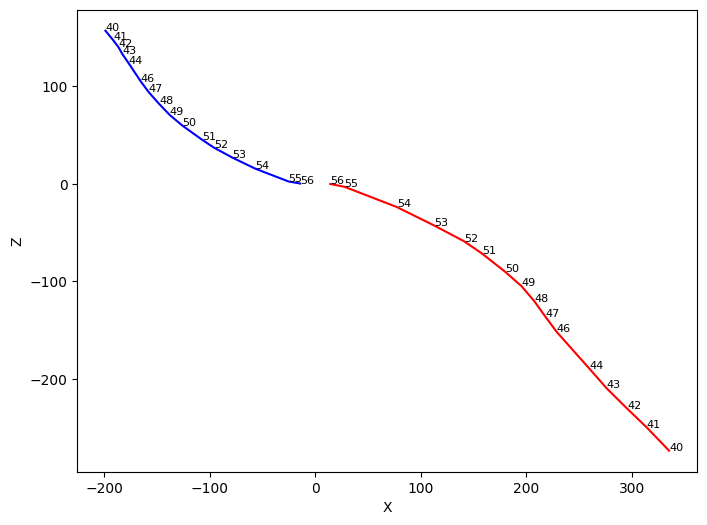

In [13]:
def mod3_df_transform(t_df):
    
    mod3_df_list = []
    
    # Iterate over every snapshot to apply COM transform
    for i, row in t_df.iterrows():
        try:
            # Get the COM position, velocity, and transformation matrix
            mod3_pos, mod3_vel = get_mod3_transform(row)
            
            # Create a new series with the transformed data
            new_data = pd.Series({
                'p_SubhaloIDRaw':    row['p_SubhaloIDRaw'],
                'mod3_pos_transform': mod3_pos,
                'mod3_vel_transform': mod3_vel,
            })
            
            # Loop through all dynamics for modification
            for p in prefix:
                # Position based vectors
                for c in pos_col:
                    new_data[f'{p}_{c}_mod3'] = pt_apply_transformation(row[f'{p}_{c}_mod2'], mod3_pos)
                                
                # Orientation vectors
                for c in angle_col:
                    new_data[f'{p}_{c}_mod3'] = pt_apply_transformation(row[f'{p}_{c}_mod2'], mod3_vel)

            # Append the new series to the current row of the DataFrame
            mod3_df_list.append(new_data)

        except Exception as e:
            print(f"Failed on index {i} with error: {e}")
            continue
    
    # Print the final dataframe for verification
    mod3_df = pd.DataFrame(mod3_df_list)
    new_df = t_df.merge(mod3_df, on='p_SubhaloIDRaw')
        
    return new_df

if buildEnv:
    t_snap = t_row['snap']
    t3_df = mod3_df_transform(t2_df)
    t3_row = t3_df[t3_df['snap'] == t_snap].iloc[0]
    
    # Plot results   
    snaps = np.stack(t3_df[t3_df['s_SubhaloPos_mod2'].notna()]['snap'].values)
    p2 = np.stack(t3_df['p_SubhaloPos_mod2'].values)
    s2 = np.stack(t3_df['s_SubhaloPos_mod2'].values)
    pv2 = np.stack(t3_df['p_SubhaloVel_mod2'].values)
    sv2 = np.stack(t3_df['s_SubhaloVel_mod2'].values)
    
    print("Target Snap", t_snap)
    mod3_pos_transform = t3_row['mod3_pos_transform']
    mod3_vel_transform = t3_row['mod3_vel_transform']
    print(mod3_pos_transform)
    
    p3 = pt_apply_transformation(p2, mod3_pos_transform)
    s3 = pt_apply_transformation(s2, mod3_pos_transform)
    
    pv3 = pt_apply_transformation(pv2, mod3_vel_transform)
    sv3 = pt_apply_transformation(sv2, mod3_vel_transform)
 
    # Plot the xz values of p1 and s1 (after modification)
    plt.figure(figsize=(8, 6))
    plt.plot(p3[:, 0], p3[:, 2], label='COM Primary', c='blue')  # XZ values
    plt.plot(s3[:, 0], s3[:, 2], label='COM Secondary', c='red')  # XZ values
    for i, snap in enumerate(snaps):
        plt.text(p3[i, 0], p3[i, 2], str(snap), fontsize=8, color='k')  # XZ values
        plt.text(s3[i, 0], s3[i, 2], str(snap), fontsize=8, color='k')  # XZ values
        
    plt.xlabel('X')
    plt.ylabel('Z')  #


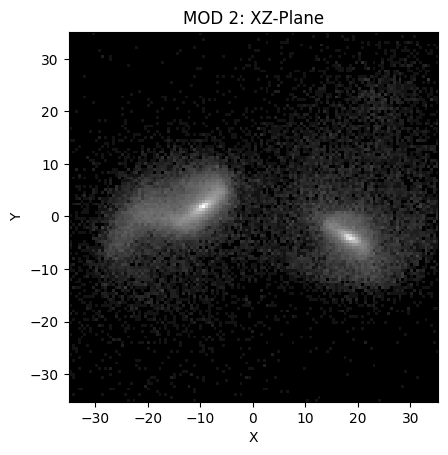

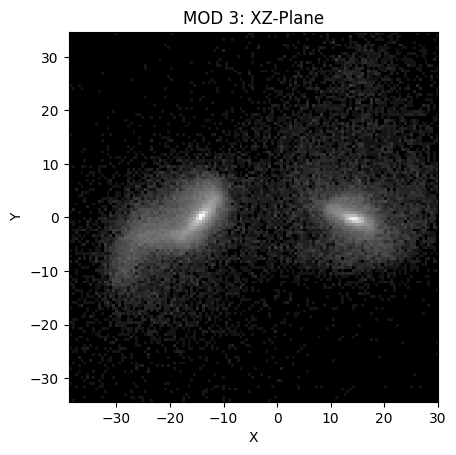

In [14]:
if buildEnv:
    pt3 = pt2.copy()
    # print(pt3.shape)
    pt3[:,0:3] = pt_apply_transformation( pt2[:,0:3], t3_row['mod3_pos_transform'] )
    pt3[:,3:6] = pt_apply_transformation( pt2[:,3:6], t3_row['mod3_vel_transform'] )
    
    # Plot positions for verification
    xy_histogram( pt2[:,[0,2]], bins=128, show_labels=True, std_dev=2, title='MOD 2: XZ-Plane' )
    xy_histogram( pt3[:,[0,2]], bins=128, show_labels=True, std_dev=2, title='MOD 3: XZ-Plane' )


In [15]:

def check_neg_z( v ):
    
    if v[2] > 0:
        return -v
    else:
        return v

def compute_pca_normal_vector(positions):
    """
    Compute the normal vector to the dominant plane using PCA.
    
    Parameters:
    -----------
    positions : numpy.ndarray
        Nx3 array representing the positions of particles (or galaxies).
    
    Returns:
    --------
    normal_vector : numpy.ndarray
        3-element array representing the normal vector to the dominant plane.
    """
    
    if positions.shape[1] > 3:
        positions = positions[:,0:3]
        
    if positions.shape[0] < 3:
        raise ValueError("At least 3 positions are required for PCA.")
        
    # Perform PCA on the positions
    pca = PCA(n_components=3)
    pca.fit(positions)
    
    # The last component is the normal vector (perpendicular to the plane)
    normal_vector = pca.components_[-1]  # The third eigenvector corresponds to the least variance (normal to plane)
    
    adjusted_vector = check_neg_z( normal_vector )
    
    return adjusted_vector

def compute_partial_rotation_to_neg_z(v):
    """
    Compute a partial rotation rotates vector v around the x-axis
    to align it with xz plane in the negative z direction.

    This rotation preserves points along the x-axis.

    Parameters:
    -----------
    v : numpy.ndarray
        3-element array representing the vector to be aligned.

    Returns:
    --------
    rotation_matrix : numpy.ndarray
        4x4 homogeneous rotation matrix that aligns v with the negative z-axis.
    """
    # Extract components of the input vector
    vx, vy, vz = v

    # Compute the angle to rotate around the x-axis to align with the negative z-axis
    theta = np.arctan2(vy, -vz)  # Rotate towards -z direction

    # Compute cos(theta) and sin(theta)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # Rotation matrix around x-axis
    R = np.array([
        [1,        0,         0],
        [0,  cos_theta, -sin_theta],
        [0,  sin_theta,  cos_theta]
    ])

    # Convert to 4x4 homogeneous rotation matrix
    rotation_4x4 = np.eye(4)
    rotation_4x4[:3, :3] = R

    return rotation_4x4



[-6.44e+01 -1.12e+05 -1.08e+05]
Mod4 transform
 [[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -4.37e-08  1.00e+00  0.00e+00]
 [ 0.00e+00 -1.00e+00 -4.37e-08  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]


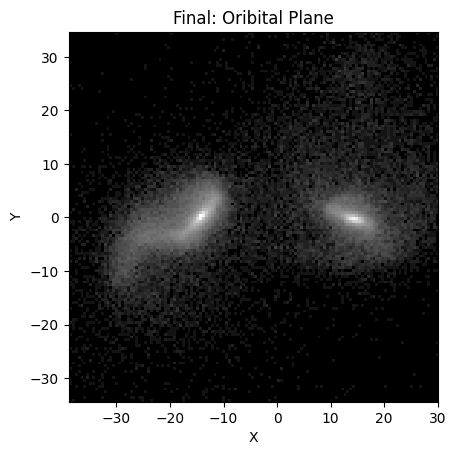

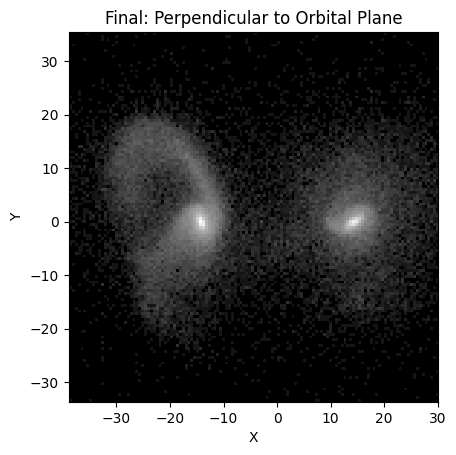

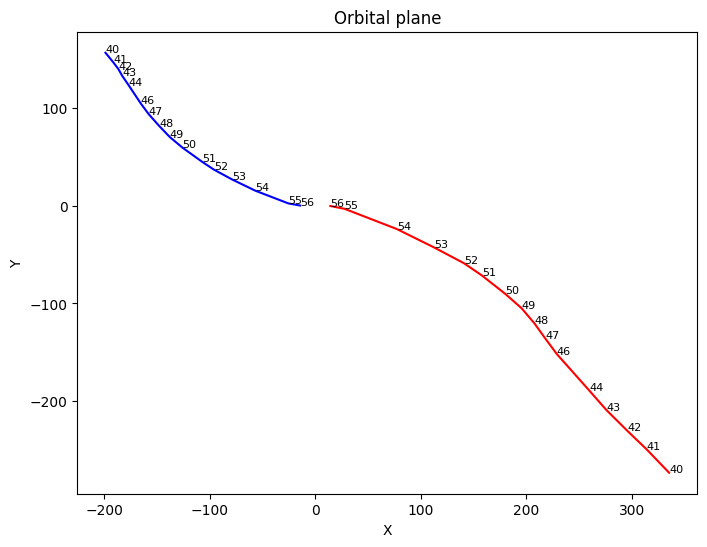

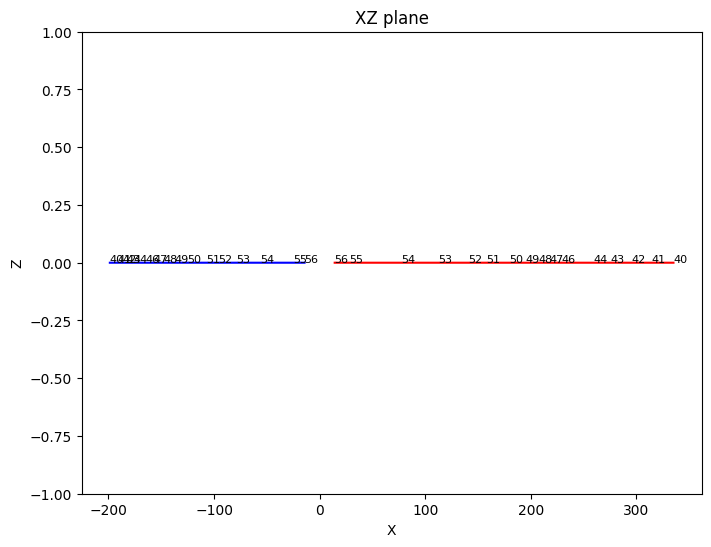

In [16]:
def mod4_df_transform(t3_df, dev_print = False):
    
    # Retrieve data of interest
    p3 = np.stack(t3_df['p_SubhaloPos_mod3'].values)
    s3 = np.stack(t3_df['s_SubhaloPos_mod3'].values)
    pv3 = np.stack(t3_df['p_SubhaloVel_mod3'].values)
    sv3 = np.stack(t3_df['s_SubhaloVel_mod3'].values)
    
    # Calculate pca vectors for entire orbit
    orbital_vector = compute_pca_normal_vector( np.vstack( [p3, s3 ] ) )
    
    # Create transformation matrices to rotate about x-axis
    orbital_transform = compute_partial_rotation_to_neg_z( orbital_vector )
    
    # Apply transform
    p4 = pt_apply_transformation(p3, orbital_transform)
    s4 = pt_apply_transformation(s3, orbital_transform)
    pv4 = pt_apply_transformation(pv3, orbital_transform[:3,:3])
    sv4 = pt_apply_transformation(sv3, orbital_transform[:3,:3])
    
    # Verify if z-component of angular momentum is positive, if not negate it
    L = np.sum(np.sum(np.cross(np.stack([p4,s4]), np.stack([pv4,sv4])), axis=0), axis=0)
    
    if dev_print: print( L )
    
    if L[2] < 0:
        orbital_vector *= -1
        orbital_transform = compute_partial_rotation_to_neg_z( orbital_vector )
        p4 = pt_apply_transformation(p3, orbital_transform)
        s4 = pt_apply_transformation(s3, orbital_transform)
        pv4 = pt_apply_transformation(pv3, orbital_transform[:3,:3])
        sv4 = pt_apply_transformation(sv3, orbital_transform[:3,:3])
    
    if dev_print: print("Mod4 transform\n", orbital_transform)
    
    # Create new dataframe with this transform
    mod4_df_list = []
    
    # Iterate over every snapshot to apply COM transform
    for i, row in t3_df.iterrows():
        try:
            
            # Create a new series with the transformed data
            new_data = pd.Series({
                'p_SubhaloIDRaw':    row['p_SubhaloIDRaw'],
                'mod4_pos_transform': orbital_transform,
                'mod4_vel_transform': orbital_transform,
            })
            
            # Loop through all dynamics for modification
            for p in prefix:
                # Position based vectors
                for c in pos_col:
                    new_data[f'{p}_{c}_mod4'] = pt_apply_transformation(row[f'{p}_{c}_mod3'], orbital_transform)
                                
                # Orientation vectors
                for c in angle_col:
                    new_data[f'{p}_{c}_mod4'] = pt_apply_transformation(row[f'{p}_{c}_mod3'], orbital_transform)

            # Append the new series to the current row of the DataFrame
            mod4_df_list.append(new_data)

        except Exception as e:
            print(f"Failed on index {i} with error: {e}")
            continue
    
    # Print the final dataframe for verification
    mod4_df = pd.DataFrame(mod4_df_list)
    new_df = t3_df.merge(mod4_df, on='p_SubhaloIDRaw')
    return new_df    

if buildEnv:
    t4_df = mod4_df_transform( t3_df, dev_print=True )
    t4_row = t4_df[ t4_df['snap'] == t_snap].iloc[0]
    
    # Apply transform
    p4 = pt_apply_transformation(p3, t4_row['mod4_pos_transform'])
    s4 = pt_apply_transformation(s3, t4_row['mod4_pos_transform'])
    
    pt4 = pt3.copy()    
    pt4[:,0:3] = pt_apply_transformation( pt3[:,0:3], t4_row['mod4_pos_transform'] )
    pt4[:,3:6] = pt_apply_transformation( pt3[:,3:6], t4_row['mod4_pos_transform'] )
    
    xy_histogram( pt4, bins=128, show_labels=True, std_dev=2, title='Final: Oribital Plane' )    
    xy_histogram( pt4[:,[0,2]], bins=128, show_labels=True, std_dev=2, title='Final: Perpendicular to Orbital Plane' )
 
    # Plot the xz values of p1 and s1 (after modification)
    plt.figure(figsize=(8, 6))
    plt.plot(p4[:,0], p4[:,1], label='COM Primary', c='blue')  # XZ values
    plt.plot(s4[:,0], s4[:,1], label='COM Secondary', c='red')  # XZ values
    for i, snap in enumerate(snaps):
        plt.text(p4[i, 0], p4[i, 1], str(snap), fontsize=8, color='k')  # XZ values
        plt.text(s4[i, 0], s4[i, 1], str(snap), fontsize=8, color='k')  # XZ values
        
    # plt.scatter( pt4[::100,0,], pt4[::100,1], s=1 )
    # plt.xlim([-100,100])
    # plt.ylim([-100,100])

    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.ylim([-300,200])
    plt.title('Orbital plane')
 
    # Plot the xz values of p1 and s1 (after modification)
    plt.figure(figsize=(8, 6))
    plt.plot(p4[:,0], p4[:,2], label='COM Primary', c='blue')  # XZ values
    plt.plot(s4[:,0], s4[:,2], label='COM Secondary', c='red')  # XZ values
    for i, snap in enumerate(snaps):
        plt.text(p4[i, 0], p4[i, 2], str(snap), fontsize=8, color='k')  # XZ values
        plt.text(s4[i, 0], s4[i, 2], str(snap), fontsize=8, color='k')  # XZ values

    plt.xlabel('X')
    plt.ylabel('Z')  
    plt.ylim([-1,1])

    plt.title('XZ plane')
    

----
# Tie it all together

All these individual transformations were to get the galaxy centers on the x-axis, and have us look down on the orbital path.  Granted the COM is probably redundant at this point but I'm leaving it in.   Let's create a new dataframe with just the final plane of reference and not all the intermediate steps.

Final Error Sum: 0.0008563939833686761
Error: 0.0008563939833686761
Hurray!
Note: A single particle is a count of 1


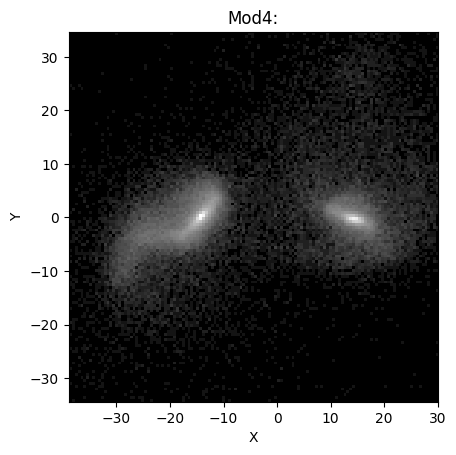

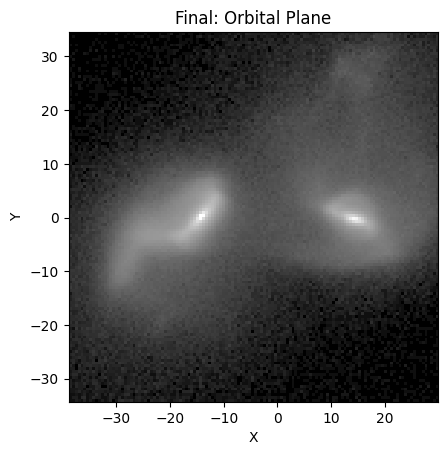

In [17]:
def orbital_df_transform( t0_df, t4_df ):
    
    # Create new dataframe with this transform
    new_df_list = []
    
    # Iterate over every snapshot to apply COM transform
    for i, row in t4_df.iterrows():
        try:
    
            # Apply all the transformations together to get the galaxies on the orbital plane.      
            total_pos_transform = row['mod1_pos_transform']
            total_pos_transform = np.dot( row['mod2_pos_transform'], total_pos_transform )
            total_pos_transform = np.dot( row['mod3_pos_transform'], total_pos_transform ) 
            total_pos_transform = np.dot( row['mod4_pos_transform'], total_pos_transform ) 

            total_vel_transform = row['mod1_vel_transform']
            total_vel_transform = np.dot( row['mod2_vel_transform'], total_vel_transform )
            total_vel_transform = np.dot( row['mod3_vel_transform'], total_vel_transform )
            total_vel_transform = np.dot( row['mod4_vel_transform'], total_vel_transform )
            
            # Create a new series with the transformed data
            new_data = pd.Series({
                'p_SubhaloIDRaw':    row['p_SubhaloIDRaw'],
                'mod1_pos_transform': row['mod1_pos_transform'],
                'mod1_vel_transform': row['mod1_vel_transform'],
                'mod2_pos_transform': row['mod2_pos_transform'],
                'mod2_vel_transform': row['mod2_vel_transform'],
                'mod3_pos_transform': row['mod3_pos_transform'],
                'mod3_vel_transform': row['mod3_vel_transform'],
                'mod4_pos_transform': row['mod4_pos_transform'],
                'mod4_vel_transform': row['mod4_vel_transform'],
                'orbital_frame_pos_transform': total_pos_transform,
                'orbital_frame_vel_transform': total_vel_transform,
            })
            
            # Loop through all dynamics for modification
            for p in prefix:
                # Position based vectors
                for c in pos_col:
                    new_data[f'{p}_{c}_orbital_frame'] = pt_apply_transformation( row[f'{p}_{c}'], total_pos_transform)
                                
                # Orientation vectors
                for c in angle_col:
                    new_data[f'{p}_{c}_orbital_frame'] = pt_apply_transformation( row[f'{p}_{c}'], total_vel_transform)

            # Append the new series to the current row of the DataFrame
            new_df_list.append(new_data)

        except Exception as e:
            print(f"Failed on index {i} with error: {e}")
            continue
    
    # Print the final dataframe for verification
    new_df = pd.DataFrame(new_df_list)
    final_df = t0_df.merge(new_df, on='p_SubhaloIDRaw')  # Merge on original/new df so it doesn't contain all the intermediate values
    return final_df    

if buildEnv:
    
    tmp_df = orbital_df_transform( t4_df, t4_df )  # Do on t4_df so I can compare directly first
    orb_df = orbital_df_transform( t_df, t4_df )
    
    # for c in tmp_df.columns:
    #     print(c)
    
    error_sum = 0.0
    
    for i, row in tmp_df.iterrows():
        for p in prefix:
            # Position based vectors
            for c in pos_col:
                tmp1 = row[f'{p}_{c}_orbital_frame']
                tmp2 = row[f'{p}_{c}_mod4']
                error_sum += np.abs(np.sum( tmp1-tmp2 ) )
    
    print(f"Final Error Sum: {error_sum}")    
    if error_sum < 1.0:  # If a single particle is off.
        print(f"Error: {error_sum}")
        print("Hurray!")
        print("Note: A single particle is a count of 1")
    else:
        print("NOOOOOO")
        
    # Let's do a quick visualization to verify particles are where I expect them to be
    pts_orb = pts.copy()    
    orb_row = orb_df[orb_df['snap'] == t_snap].iloc[0]
    
    pts_orb[:,0:3] = pt_apply_transformation( pts_orb[:,0:3], orb_row['orbital_frame_pos_transform'] )
    pts_orb[:,3:6] = pt_apply_transformation( pts_orb[:,3:6], orb_row['orbital_frame_vel_transform'] )
    xy_histogram( pt4, bins=128, show_labels=True, std_dev=2, title='Mod4:' )
    xy_histogram( pts_orb, bins=128, show_labels=True, std_dev=2, title='Final: Orbital Plane' )
 
      

In [18]:

def func_wrapper_orbital_frame( args, dev_print=False ):
    
    print("Wrapper for Calculating the orbital frame from dynamics data")
    
    # Default location
    old_file_loc = args.dataDir + 'moi-3-dynamics.pkl'
    
    # If specific location given
    if args.inputFile is not None:
        old_file_loc = args.inputFile
        
    # Define save loc for new file
    new_save_loc = old_file_loc.replace('.', '-orbital-frame.')
    
    assert os.path.exists( old_file_loc ), f'Target information file not found: {old_file_loc}'
    tf.tabprint(f"Reading Target info File: {old_file_loc}")
    
    # Read potential tng targets file
    moi_df = pd.read_pickle( old_file_loc )
    tf.tabprint( f"ALL Targets Shape {moi_df.shape}")
    
    # Let's add some extra data I forgot to do earlier
    moi_df['pa_SubhaloPos'] = moi_df['p_SubhaloPos']
    moi_df['ps_SubhaloPos'] = moi_df['p_SubhaloPos']
    moi_df['sa_SubhaloPos'] = moi_df['s_SubhaloPos']
    moi_df['ss_SubhaloPos'] = moi_df['s_SubhaloPos']
    
    # Create a dict to reference times
    snap_to_time = {}
    for i in range(tf.snapshot_data['snapshots'].shape[0]):
        snap_to_time[tf.snapshot_data['snapshots'][i] ] = tf.snapshot_data['Gyr'][i]
    
    # Loop through all targets 
    for i, row in moi_df.iterrows():
        moi_df.at[i, 'time_gyr'] = snap_to_time[ row['snap'] ]
    
    # print( moi_df['time_gyr'] )
            
    # Check if specific target was given
    if args.targetID is not None:
        t_id = args.targetID
        moi_df = moi_df[moi_df['moi_2'] == t_id]
        tf.tabprint( f'Single target: {t_id} - {moi_df.shape} ' )
    
    all_targets_df = pd.DataFrame(columns=['moi_2','snap'])  # Create an empty DataFrame if no file exists
        
    # Loop through moi-2 values for processing
    moi_2_list = moi_df['moi_2'].unique().tolist()
    tf.tabprint(f"Processing {len(moi_2_list)} targets")
    
    for i, t_id in enumerate(moi_2_list):
        
        print( i, t_id, end='\r' )
        
        # Get subset specific to target
        t_df = moi_df[moi_df['moi_2'] == t_id]
        
        try:
    
            # # Start modifying datasets            
            t0_df = t_df[ t_df['pa_SubhaloCM'].notna() ] # Get clean df to prevent errors.
            t1_df = mod1_df_transform( t0_df )
            t2_df = mod2_df_transform( t1_df )
            t3_df = mod3_df_transform( t2_df )
            t4_df = mod4_df_transform( t3_df )
            new_orb_df = orbital_df_transform( t_df, t4_df )

            # Append new row to the existing DataFrame
            all_targets_df = pd.concat([all_targets_df, new_orb_df], ignore_index=True)
            
        except:
            pass

        if dev_print: print( i, new_orb_df.shape, all_targets_df.shape )
    # END Loop  
    print('\nCompleted Orbital Dynamics Wrapper')
    
    # Save the updated DataFrame to avoid losing progress
    all_targets_df.to_pickle(new_save_loc)
    all_targets_df.to_csv(new_save_loc.replace('.pkl', '.csv'), index=False)
    gc.collect()

    # End main loop

if buildEnv and False:  # Use compiled script from cmd line for speed. 
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_images.py'
    cmdStr += ' --function orbital_frame'
    cmdStr += ' --dataDir tng-data/'
    # cmdStr += ' --inputFile tng-data/moi-3-dynamics.pkl'
    cmdStr += ' --inputFile tng-data/moi_4-test-dynamics.pkl'
    # cmdStr += ' --targetID 67000000258162'
    cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])
    
if script_args.function == 'orbital_frame':
    func_wrapper_orbital_frame( script_args )
    print('DONE')

---
# IMAGES!

Okay!  That was a long tangent to standardize the reference frame.  Now let's actually automate some images!

Orb File:  (67, 110)
Primary ID: 56000000230959
Target DF: (16, 110)
Getting Particles for Plotting
56 230959 230960
	 - Getting Subhalo Particles: 230959
	 - Getting Subhalo Particles: 230960
	 - Getting Historical Labels: 
Calculating Historical Ownership (via Dictionary): 67000000258162
	 - Files already created
	 - Conjoining Labels w/ Particles: 
Pts:  (2660971, 3) (2660971, 3) (2660971, 1) (2660971, 1)
Raw Pts: (2660971, 8)


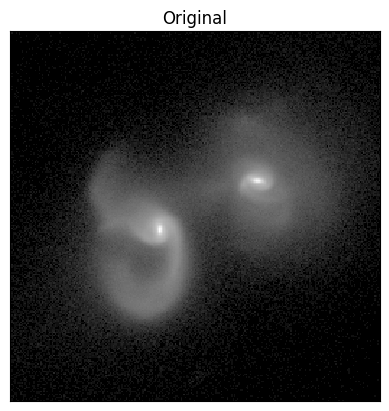

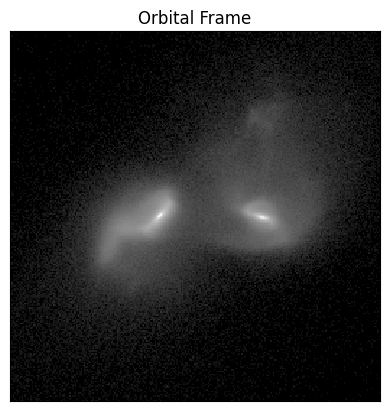

In [19]:
def get_orbital_file( args, name = 'moi-3-dynamics' ):
    file_loc = os.path.join(args.dataDir, f'{name}-orbital-frame.pkl')

    df = pd.read_pickle( file_loc )
    # print( df.shape )
    return df

def get_orbital_frame_pts( t_df, t_row=None, t_snap=None, sample_n=-1, dev_print=False):
    """
    Get the particles for a target and tranforms them into the orbital frame.

    Args:
    -----
    t_df (pd.DataFrame): Information about the target galaxies over time.
    t_row (pd.Series): Information about the target galaxies at a snapshot.
    t_snap (int): Snapshot number for the current target of interest.

    Returns:
    --------
    orbital_frame_pts (np.ndarray): Nx8 particle data 
                                [x,y,z,vx,vy,vz, subhalo_label, historical_label]
    
    """
        
    if t_row is None and t_snap is None:
        raise ValueError(f"Either t_row or t_snap must be given")
        
    if t_row is None:
        t_row = t_df[ t_df['snap'] == t_snap ].iloc[0]

    # RAW POINTS
    pts = get_plot_pts( t_row, t_df, dev_print=dev_print )
    if dev_print: print( f'Raw Pts: {pts.shape}' )
    
    if sample_n != -1:
        # Let's grab a subsample of particles to visualize transformations
        indices = np.random.choice( pts.shape[0], sample_n, replace=False)
        pts = pts[indices]
        if dev_print: print( f'Sample PTS: {pts.shape}' )
    
    
    if dev_print: xy_histogram( pts, title= 'Original' )

    # Edit points in place so not to create excess data in memory
    pts[:,0:3] = pt_apply_transformation( pts[:,0:3], t_row['orbital_frame_pos_transform'] )
    pts[:,3:6] = pt_apply_transformation( pts[:,3:6], t_row['orbital_frame_vel_transform'] )
    
    if dev_print: xy_histogram( pts, title='Orbital Frame')

    return pts


if buildEnv:
    
    # Let's verify we can read the orbital file and transform points
    orb_df = get_orbital_file( script_args, name = 'moi_4-test-dynamics' )
    print( 'Orb File: ', orb_df.shape )
    
    # Extract dev target
    print( 'Primary ID:', pid )
    t_row = orb_df[ orb_df['p_SubhaloIDRaw'] == pid ].iloc[0]
    sid = t_row['s_SubhaloIDRaw']
    t_id = t_row['moi_2']
    t_df = orb_df[ orb_df['moi_2'] == t_id ]
    print( 'Target DF:', t_df.shape )
    # print( 'Columns:', list(t_df.columns) )

    pts = get_orbital_frame_pts( t_df, t_row, dev_print = True )
    

In [20]:
def compute_complete_rotation_to_neg_z(normal_vector, end_vector=np.array([0, 0, -1])):
    """
    Compute a 4x4 rotation matrix to align the given vector with the end vector.
    The rotation occurs in two steps:

    Parameters:
    -----------
    normal_vector : numpy.ndarray
        3-element array representing the normal vector to align.
    end_vector : numpy.ndarray, optional
        3-element array representing the target direction (default is [0, 0, -1]).

    Returns:
    --------
    rotation_4x4 : numpy.ndarray
        4x4 homogeneous transformation matrix that aligns the normal vector with the end vector.
    """
    # Normalize input vectors
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    end_vector = end_vector / np.linalg.norm(end_vector)

    # Step 1: Rotate the normal vector around the x-axis to align it with the xz-plane.
    # Project the normal vector onto the yz-plane (ignore x-component).
    projection = np.array([0, normal_vector[1], normal_vector[2]])
    if np.linalg.norm(projection) > 0:  # Avoid division by zero
        projection /= np.linalg.norm(projection)

    # Compute angle to rotate around the x-axis to bring the vector to the xz-plane.
    theta_x = np.arccos(projection[1])  # Angle between projection and y-axis

    # Determine the direction of the rotation based on the z-component
    if normal_vector[2] < 0:
        theta_x = -theta_x

    # Rotation matrix around the x-axis
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])

    # Apply the first rotation to align the vector with the xz-plane
    rotated_vector = np.dot(Rx, normal_vector)

    # Step 2: Rotate around the z-axis to align with the end vector direction.
    # Compute the angle between the rotated vector (on the xz-plane) and the end vector.
    cos_theta_z = np.dot(rotated_vector, end_vector)
    theta_z = np.arccos(np.clip(cos_theta_z, -1.0, 1.0))  # Avoid precision errors

    # Compute the rotation axis for the z-rotation (cross product)
    rotation_axis = np.cross(rotated_vector, end_vector)
    if np.linalg.norm(rotation_axis) > 0:  # Avoid division by zero
        rotation_axis /= np.linalg.norm(rotation_axis)

    # Rodrigues' formula to create the rotation matrix around the z-axis
    K = np.array([
        [0, -rotation_axis[2], rotation_axis[1]],
        [rotation_axis[2], 0, -rotation_axis[0]],
        [-rotation_axis[1], rotation_axis[0], 0]
    ])
    Rz = np.eye(3) + np.sin(theta_z) * K + (1 - np.cos(theta_z)) * np.dot(K, K)

    # Combine the two rotations: Rx (around x-axis) and Rz (around z-axis)
    R_combined = np.dot(Rz, Rx)

    # Convert to 4x4 homogeneous transformation matrix
    rotation_4x4 = np.eye(4)
    rotation_4x4[:3, :3] = R_combined  # Embed 3x3 rotation in the 4x4 matrix

    return rotation_4x4



if buildEnv and False:
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create rid of plots
    
    # Get individual galaxy particles
    p_mask = pts_0[:,7] == 0
    p_pts_0 = pts_0[p_mask]
    s_pts_0 = pts_0[~p_mask]
    
    xy_histogram( p_pts_0, ax=axes[0], title='Primary Orbital POV')
    xy_histogram( s_pts_0, ax=axes[1], title='Secondary Orbital POV')
    
    # Create plot
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Create 3x3 grid of plots
    
#     print(axes.shape )

#     # Adjust layout for better visualization
#     fig.tight_layout(pad=3.0)

    # Calculate alternate primary views
    primary_vector = compute_pca_normal_vector( p_pts_0 )
    primary_transform = compute_complete_rotation_to_neg_z( primary_vector )
    primary_z_transform = compute_partial_rotation_to_neg_z( primary_vector )
    p_pts = pt_apply_transformation( p_pts_0, primary_transform, primary_transform )
    xy_histogram( p_pts, ax=axes[0,0], title='Primary Tidal POV' )
    tmp_pts = pt_apply_transformation( pts_0, primary_transform, primary_transform )
    xy_histogram( tmp_pts, ax=axes[0,1], title='All w/ primary view' )
    tmp_pts = pt_apply_transformation( pts_0, primary_z_transform, primary_z_transform )
    xy_histogram( tmp_pts, ax=axes[0,2], title='All w/ primary z view' )

    # Calculate alternate secondary views
    secondary_vector = compute_pca_normal_vector( s_pts_0 )
    secondary_transform = compute_complete_rotation_to_neg_z( secondary_vector )
    secondary_z_transform = compute_partial_rotation_to_neg_z( secondary_vector )
    s_pts = pt_apply_transformation( s_pts_0, secondary_transform, secondary_transform )
    xy_histogram( s_pts, ax=axes[1,0], title='Secondary Tidal POV' )
    tmp_pts = pt_apply_transformation( pts_0, secondary_transform, secondary_transform )
    xy_histogram( tmp_pts, ax=axes[1,1], title='All w/ Secondary view' )
    tmp_pts = pt_apply_transformation( pts_0, secondary_z_transform, secondary_z_transform )
    xy_histogram( tmp_pts, ax=axes[1,2], title='All w/ Secondary Z view' )
    
    # Total PCA/Tidal of all points
    total_tidal_vector = compute_pca_normal_vector( pts )
    total_tidal_transform = compute_complete_rotation_to_neg_z( total_tidal_vector )
    total_z_tidal_transform = compute_partial_rotation_to_neg_z( total_tidal_vector )
    tmp_pts = pt_apply_transformation( pts_0, total_tidal_transform )
    xy_histogram( tmp_pts, ax=axes[2,0], title='Total XY Tidal' )
    tmp_pts = pt_apply_transformation( pts_0, total_z_tidal_transform )
    xy_histogram( tmp_pts, ax=axes[2,1], title='Total Z Tidal' )
        

In [21]:
def create_img( pts_in, pov_vector, name, t_row, std_dev=3, bins=256, dev_print =True):
    """
    Generates a 2D histogram matrix from xy_data as float32.
    Also calculates the pixel centers of primary and secondary galaxies.

    Args:
    -----
    pts_in (np.ndarray): An N x 2 array of xy coordinates.
    pov_vector (np.ndarray): A 3-element vector for the POV transformation.
    name (str): The name of the image.
    t_row (pd.Series): The row containing primary and secondary galaxy positions.
    std_dev (float): Number of standard deviations to set axis limits.
    bins (int): Number of bins along each axis in the histogram.

    Returns:
    --------
    h (np.ndarray): The 2D histogram matrix as float32.
    meta (dict): A dictionary containing image meta data, including galaxy pixel centers.
    """
    
    if dev_print: print(f"Creating Image: {name}")
    
    if pts_in is None:
        raise ValueError("xy_data cannot be None")
    
    pts = pts_in.copy()
    
    # Calculate the tranform for the vector
    pov_transform = compute_complete_rotation_to_neg_z( pov_vector )
    
    # Apply tranform to pts
    if dev_print: tf.tabprint("Applying Transform")
    pts = pt_apply_transformation( pts, pov_transform )    
        
    # Calculate the mean and standard deviation
    mean_xy = np.mean(pts[:, :2], axis=0)
    std_xy = np.std(pts[:, :2], axis=0)

    # Determine the maximum range to use for both axes
    max_range = np.max(std_xy) * std_dev

    # Set axis limits to be the same for both x and y
    xlim = (mean_xy[0] - max_range, mean_xy[0] + max_range)
    ylim = (mean_xy[1] - max_range, mean_xy[1] + max_range)

    # Create the histogram
    if dev_print: tf.tabprint("Binning Particles")
    img, xedges, yedges = np.histogram2d(
        pts[:, 0], pts[:, 1],
        bins=bins, range=[xlim, ylim]
    )

    # Convert to float32
    img = img.astype(np.float32)
    
    # Generate meta data dict
    if dev_print: tf.tabprint("Creating Metadata")
    meta = {}
    meta['name'] = name
    meta['x_limits'] = xlim
    meta['y_limits'] = ylim
    meta['num_particles'] = pts.shape[0]
    meta['bin_resolution'] = bins
    meta['std_dev'] = std_dev
    meta['pov_vector'] = pov_vector
    meta['pov_transform'] = pov_transform
    
    # Get galactic centers to calculate pixel centers
    p = t_row['p_SubhaloPos_orbital_frame']
    s = t_row['s_SubhaloPos_orbital_frame']
    p_pov = pt_apply_transformation( p, pov_transform )
    s_pov = pt_apply_transformation( s, pov_transform )
    
    def calc_pixel_center(pos, xedges, yedges):
        
        # Find the bin index for x and y positions
        x_idx = np.digitize([pos[0]], xedges)[0] - 1  # Get the x bin index
        y_idx = np.digitize([pos[1]], yedges)[0] - 1  # Get the y bin index

        # Ensure indices are within bounds
        x_idx = np.clip(x_idx, 0, len(xedges) - 2)
        y_idx = np.clip(y_idx, 0, len(yedges) - 2)

        return y_idx, x_idx  # Return as (row, col)
    
    # Calculate pixel centers of galaxies
    meta['primary_pixel_center'] = calc_pixel_center( p_pov, xedges, yedges )
    meta['secondary_pixel_center'] = calc_pixel_center( s_pov, xedges, yedges )
    
    # Clean up
    del pts
    gc.collect()

    return img, meta


if buildEnv:
    
    # Get individual galaxy particles
    p_mask = pts[:,7] == 0
    p_pts = pts[p_mask]
    s_pts = pts[~p_mask]
    
    o_img, o_meta = create_img( pts, np.array([0,0,-1]), name='Orbital Frame', t_row=t_row,  dev_print=True )
    
    for k, v in o_meta.items():
        tf.tabprint( f"{k} - {v}" )
    
#     primary_vector = compute_pca_normal_vector( p_pts )
#     p_img, p_meta = create_img( pts, t_row, transform, name='Orbital Frame', dev_print=True )

#     # print( img_meta_list )
#     print("DONE")
    

Creating Image: Orbital Frame
	 - Applying Transform
	 - Binning Particles
	 - Creating Metadata
	 - name - Orbital Frame
	 - x_limits - (-56.13133967300952, 47.15364880605365)
	 - y_limits - (-51.53445297900909, 51.750535500054085)
	 - num_particles - 2660971
	 - bin_resolution - 256
	 - std_dev - 3
	 - pov_vector - [ 0  0 -1]
	 - pov_transform - [[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  1.00e+00  4.98e-17  0.00e+00]
 [ 0.00e+00 -4.98e-17  1.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
	 - primary_pixel_center - (128, 103)
	 - secondary_pixel_center - (127, 174)


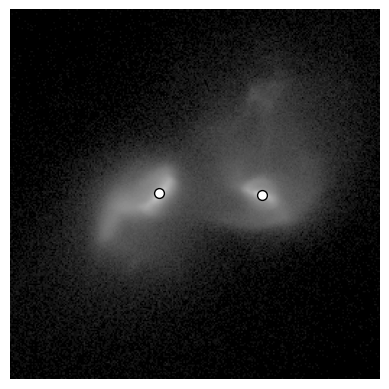

In [22]:
def visualize_image(img_in, pixel_centers=None, log_scale=True, cmap='gray'):
    """
    Visualizes the histogram matrix with optional log scaling.

    Args:
    -----
    h (np.ndarray): The histogram matrix to display.
    log_scale (bool): Whether to apply logarithmic scaling for visualization.
    cmap (str): Colormap for rendering the image.

    Returns:
    --------
    None
    """
    
    img = img_in.copy()
    # Apply log scaling if desired
    if log_scale:
        # Avoid taking log of zero
        img = np.log1p(img)
    
    # Normalize the data to [0, 1]
    h_min = np.min(img)
    h_max = np.max(img)
    img_normalized = (img - h_min) / (h_max - h_min) 
    
    # If pixel_center is provided, plot it on the image
    if pixel_centers is not None:
        for center in pixel_centers:
            plt.scatter(center[1], center[0], c='white', s=50, edgecolors='black', label='Center')
    
    plt.imshow(img_normalized.T, cmap=cmap, origin='lower')
    plt.axis('off')
    plt.show()

if buildEnv:
    visualize_image( o_img, pixel_centers=[o_meta['primary_pixel_center'], o_meta['secondary_pixel_center']], )


In [ ]:
def gen_std_pov_img( pts, t_row, dev_print=False ):
    
    print("Generating Standard Target POVs")
    
    # standard image list
    img_meta_list = []
        
    # Create plot
    # Get individual galaxy particles
    p_mask = pts[:,7] == 0
    p_pts = pts[p_mask]
    s_pts = pts[~p_mask]
    
    
    # Orbital view
    if dev_print: tf.tabprint( 'Creating Orbital Image')
    img_meta_list.append( create_img( pts, np.array([0,0,-1]), \
                                     name='orbital_frame', t_row=t_row,  \
                                     dev_print=True )
                        )  
    
    # Calculate Primary views
    if dev_print: tf.tabprint( 'Creating Primary POVs')
    primary_vector = compute_pca_normal_vector( p_pts )
    
    img_meta_list.append( create_img( pts, primary_vector, 
                                     name='tidal_primary_all', 
                                     t_row=t_row, 
                                     dev_print=True )
                        )
    
    img_meta_list.append( create_img( p_pts, primary_vector, 
                                     name='tidal_primary_solo', 
                                     t_row=t_row, 
                                     dev_print=True )
                        )
    
    
    
    # Calculate Secondary views
    if dev_print: tf.tabprint( 'Creating Secondary POVs')
    secondary_vector = compute_pca_normal_vector( s_pts )
    
    img_meta_list.append( create_img( pts, secondary_vector, 
                                     name='tidal_secondary_all', 
                                     t_row=t_row, 
                                     dev_print=True )
                        )
    
    img_meta_list.append( create_img( s_pts, secondary_vector, 
                                     name='tidal_secondary_solo', 
                                     t_row=t_row, 
                                     dev_print=True )
                        )

    
    
    return img_meta_list
    
if buildEnv:
    img_meta_list = gen_std_pov_img( pts, t_row, dev_print=True )
    
    print("Created images")
    for img, meta in img_meta_list:
        tf.tabprint( f"{meta['name']}: {img.shape}" )
    # print( img_meta_list )
    print("DONE")

Generating Standard Target POVs
	 - Creating Orbital Image
Creating Image: orbital_frame
	 - Applying Transform


In [ ]:
def is_valid_h5_type(value):
    """
    Check if a value is a valid HDF5 attribute type.
    """
    # Allowed types for HDF5 attributes
    valid_types = (int, float, str, bool, np.ndarray, bytes)

    # Check simple types
    if isinstance(value, valid_types):
        # Ensure numpy arrays are small enough for attributes
        if isinstance(value, np.ndarray) and value.size > 100:
            return False  # Arbitrary size limit for attributes
        return True

    # Check lists with valid elements
    elif isinstance(value, list):
        return all(isinstance(v, (int, float, str, bool)) for v in value)

    # If type is not recognized, return False
    return False

def validate_h5_dict(data):
    """
    Validate a dictionary's values to ensure they are compatible with HDF5 attributes.

    Args:
    -----
    data (dict): The dictionary to validate.

    Returns:
    --------
    valid (bool): True if all values are valid, False otherwise.
    invalid_keys (list): List of keys with invalid values.
    """
    invalid_keys = [k for k, v in data.items() if not is_valid_h5_type(v)]
    
    if invalid_keys:
        print(f"Invalid keys: {invalid_keys}")
        return False, invalid_keys
    else:
        print("All values are valid for HDF5 attributes.")
        return True, []

if buildEnv:
    # Example usage
    test_dict = {
        'valid_int': 42,
        'valid_float': 3.14,
        'valid_str': 'hello',
        'valid_bool': True,
        'valid_array': np.array([1, 2, 3]),
        'valid_list': [1, 2, 3],
        'invalid_large_array': np.random.rand(200),  # Too large for attributes
        'invalid_object': object()  # Unsupported type
    }

    # Validate the dictionary
    print('\nExample')
    valid, invalid_keys = validate_h5_dict(test_dict)
    
    row_dict = t_row.to_dict()
    
    print("\nTarget Row Data")
    _, invalid_keys = validate_h5_dict( row_dict )

    print("\nYes")

In [ ]:

def store_images_h5(hdf_file, img_list, pid = None, t_row=None):
    """
    Stores a set of images and their metadata in a nested HDF5 structure.

    Args:
    -----
    hdf_file (str): Path to the HDF5 file.
    pid (int): ID of the primary galaxy.
    img_list (list): List of tuples with (image_matrix, metadata_dict).
    t_row (pd.Series, optional): Target metadata to store in the HDF5 group.

    Example:
    --------
    images_with_meta = [
        (img_1, {'name':'Orbital_Frame', 'num_particles': 2000, 'x_limits':[-10,10]}),
        (img_2, {'name':'Primary_Tidal', 'num_particles': 1000, 'x_limits':[-10,0]}),
    ]
    """
        
    if pid is None and t_row is None:
        raise ValueError(f"Either pid or t_row must be given")
        
    if pid is None:
        pid = t_row['p_SubhaloIDRaw']
        
    with h5py.File(hdf_file, 'a') as hdf:
        # Create (or open) the group for the target
        target_group = hdf.require_group(f'Target_{int(pid)}')

        # Add target metadata if provided
        if t_row is not None:
            t_dict = t_row.to_dict()
            for k, v in t_dict.items():
                target_group.attrs[k] = v

        # Loop through the images and their metadata
        for image_matrix, metadata in img_list:
            image_name = metadata['name']

            # Create or open the image group
            image_group = target_group.require_group(f'Image_{image_name}')

            # Handle the dataset: overwrite if it exists
            if 'histogram_matrix' in image_group:
                del image_group['histogram_matrix']  # Delete the existing dataset

            # Create the dataset with the image matrix
            image_dataset = image_group.create_dataset(
                'histogram_matrix',
                data=image_matrix,
                compression='gzip'  # Optional: Enable compression to save space
            )

            # Add metadata as attributes to the dataset
            for key, value in metadata.items():
                image_dataset.attrs[key] = value

if buildEnv:
    test_save = 'tng-data/test-img-storage.h5' 
    store_images_h5( test_save, img_meta_list, t_row = t_row )
    store_images_h5( test_save, img_meta_list, pid=12 )
    print("Done")
    

In [ ]:
def get_all_targets_meta(hdf_file):
    """
    Retrieves metadata and image names for all targets found in the HDF5 file.

    Args:
    -----
    hdf_file (str): Path to the HDF5 file.

    Returns:
    --------
    all_targets_meta (dict): A dictionary where the keys are target IDs (pids) and the values are dictionaries
                             containing the target metadata and a list of image names.
    """
    all_targets_meta = {}
    
    if not os.path.exists( hdf_file ):
        return {}

    with h5py.File(hdf_file, 'r') as hdf:
        # Iterate through all groups in the HDF5 file
        for group_name in hdf.keys():
            if group_name.startswith('Target_'):
                # Extract the target ID (pid) from the group name
                pid = group_name

                # Access the target group
                target_group = hdf[group_name]

                # Retrieve the target metadata
                t_meta = {key: target_group.attrs[key] for key in target_group.attrs}

                # Get the list of image names (keys starting with 'Image_')
                image_names = [key for key in target_group.keys() if key.startswith('Image_')]

                # Store metadata and image names in the dictionary with pid as the key
                all_targets_meta[pid] = {
                    'metadata': t_meta,
                    'image_names': image_names
                }

    return all_targets_meta

if buildEnv:
    all_meta = get_all_targets_meta( test_save )
    print( all_meta.keys() )
    print( all_meta['Target_12'] )
    print( all_meta['Target_12']['image_names'] )

In [ ]:
def func_wrapper_create_std_images( args, dev_print=False ):
    
    print("Wrapper for Generating standard images for orbital frame")
    
    # Default location
    old_file_loc = args.dataDir + 'moi-3-dynamics-orbital-frame.pkl'
    
    # If specific location given
    if args.inputFile is not None:
        old_file_loc = args.inputFile
        
    # Define save loc for new file
    h5_save_loc = old_file_loc.replace('-dynamics-orbital-frame.pkl', '-std-images.h5')
    
    assert os.path.exists( old_file_loc ), f'Target information file not found: {old_file_loc}'
    tf.tabprint(f"Reading Target info File: {old_file_loc}")
    
    # Read potential tng targets file
    moi_df = pd.read_pickle( old_file_loc )
    tf.tabprint( f"ALL Targets Shape {moi_df.shape}")

    # Check if specific target was given
    if args.targetID is not None:
        t_id = args.targetID
        moi_df = moi_df[moi_df['moi_2'] == t_id]
        tf.tabprint( f'Single target: {t_id} - {moi_df.shape} ' )
        
    # Get meta data if file already exists
    img_metadata = get_all_targets_meta( h5_save_loc )  
    
    def std_imgs_found( pid, img_metadata ):
        
        t_dict = img_metadata.get( f'Target_{int(pid)}', None )
        if t_dict is None:  return False
        
        img_list = t_dict['image_names']
        if 'Image_orbital_frame' in img_list \
        and 'Image_tidal_primary_all' in img_list \
        and 'Image_tidal_primary_solo' in img_list \
        and 'Image_tidal_secondary_all' in img_list \
        and 'Image_tidal_secondary_solo' in img_list:
            return True
        else:
            return False
        
    # Loop through moi-2 values for processing
    moi_2_list = moi_df['moi_2'].unique().tolist()
    tf.tabprint(f"Processing {len(moi_2_list)} targets")
    
    for i, t_id in enumerate(moi_2_list):
        
        print( i, t_id )
                
        # Get subset specific to target
        t_df = moi_df[moi_df['moi_2'] == t_id]
        
        for j, t_row in t_df.iterrows():
            
            # Print progress
            tf.tabprint( f"{i} - {j}: ", end='\r' )
            if dev_print: tf.tabprint( f"{i} - {j}: " )
            
            # Extract target info
            pid = t_row['p_SubhaloIDRaw']
            
            # Check if images exist
            img_found = std_imgs_found( pid, img_metadata )
            if img_found and not args.overwrite:
                if dev_print: tf.tabprint(f"Skipping: {pid}")
                continue
            
            # Get pts
            pts = get_orbital_frame_pts( t_df, t_row, dev_print = True )
            
            # Generate images
            img_meta_list = gen_std_pov_img( pts, t_row, dev_print=True )
            
            # Save images and target metadata
            store_images_h5( h5_save_loc, img_meta_list, t_row = t_row )
        
        # End looping snaps for collision over time
        
    # End looping collisions         
        
    print('\nCompleted Generating Images')
    
# End Gen std images

if buildEnv and False:  # Use compiled script from cmd line for speed. 
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_images.py'
    cmdStr += ' --function create_std_images'
    cmdStr += ' --dataDir tng-data/'
    cmdStr += ' --inputFile tng-data/moi-3-dynamics-orbital-frame.pkl'
    # cmdStr += ' --inputFile tng-data/moi_4-test-dynamics-orbital-frame.pkl'
    # cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])

print(f"Script Function: {script_args.function}")
if script_args.function == 'create_std_images':
    func_wrapper_create_std_images( script_args, dev_print=False )


In [ ]:
def rotate_vector(angle_degrees, axis = 'x', vector = np.array([0, 0, -1]) ):
    # Convert angle to radians
    
    if angle_degrees < 0: angle_degrees += 360
    angle_radians = np.radians(angle_degrees)
    
    # Define the rotation matrix based on the axis
    if axis == 'x':
        rotation_matrix = np.array([[1, 0, 0],
                                    [0, np.cos(angle_radians), -np.sin(angle_radians)],
                                    [0, np.sin(angle_radians), np.cos(angle_radians)]])
    elif axis == 'y':
        rotation_matrix = np.array([[np.cos(angle_radians), 0, np.sin(angle_radians)],
                                    [0, 1, 0],
                                    [-np.sin(angle_radians), 0, np.cos(angle_radians)]])
    elif axis == 'z':
        rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians), 0],
                                    [np.sin(angle_radians), np.cos(angle_radians), 0],
                                    [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")

    # Rotate the vector using the rotation matrix
    rotated_vector = np.dot(rotation_matrix, vector)
    
    return rotated_vector

    
if buildEnv and True:
    import plotly.graph_objects as go
    fig = go.Figure()
    
    for dx in np.linspace( -90, 90, 9 ):
        for dy in np.linspace( 0, 90, 4 ):
            
            if dx == -90: continue
            # if dx == 90: continue
            
            if dy == 90: 
                ddy_list = [ dy ]
            else: 
                ddy_list = [ -dy, dy ]
            
            
            for ddy in ddy_list:
            
                v1 = rotate_vector(dx, axis = 'x' )
                v2 = rotate_vector(ddy, axis = 'y' )   

                # Compute the rotation matrices (replace with actual logic)
                t1 = compute_rotation_matrix_to_align_with_xy(v1)
                t2 = compute_rotation_matrix_to_align_with_xy(v2)

                # Apply both rotation matrices to the vectors
                tmp_t1 = np.dot(t2, t1)  # Rotate YZ vector 
                img_v1 = pt_apply_transformation( np.array([0,0,1]), tmp_t1 )

                # Plot the combined vector (starting at the origin)
                fig.add_trace(go.Scatter3d(
                    x=[img_v1[0],0], y=[img_v1[1],0], z=[img_v1[2],0],
                    marker=dict(size=4),
                    line=dict(color='blue', width=2),
                    name='Img View'
                ))

    # Set plot layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-1, 1], title='X'),
            yaxis=dict(range=[-1, 1], title='Y'),
            zaxis=dict(range=[-1, 1], title='Z')
        ),
        title="Interactive 3D Vector Plot",
        width=800,  # Change this value to adjust width
        height=600  # Change this value to adjust height
    )

    # Show the interactive plot
    fig.show()
            

#     yz_vectors = generate_yz_unit_vectors(num_yz_angles)
#     xz_vectors = generate_xz_unit_vectors(num_xz_angles)

#     # Create the interactive plot
#     plot_vectors_interactive(yz_vectors, xz_vectors)


## (FAILED) Stellar Photometrics

It turns out, the test target I was using for my sample, happened to land on a full snapshot.  Thus I loaded the star photometrics and created realistic images via actual wavelenths.  However, the mini snapshots don't have this value so I probably won't be using this for my image creation.... sadly.  But perhaps for a few targets later on once I actually go through all the images to identify tidal features.

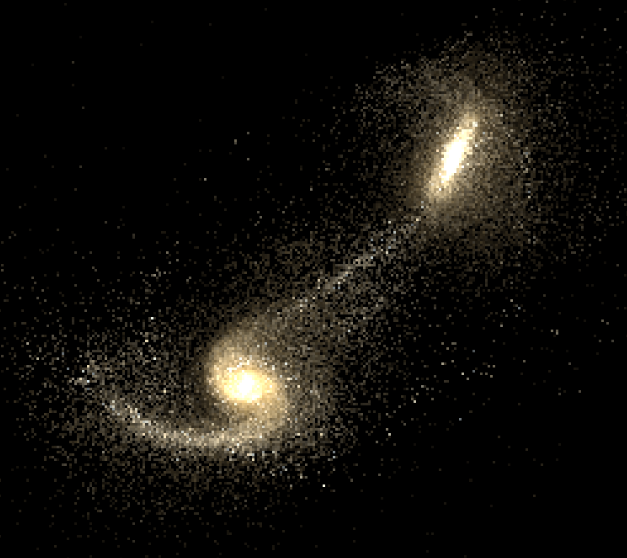


In [ ]:
if buildEnv and False:
    # id1, id2, 
    img_size = (128,128), 
    std_dev = 3
    
    for i, row in m_df.iterrows():
        
        # Skip rows without tidal features
        # if row['moi_4'] == False:  continue
        
        
        _, pid = tf.deconstruct_subhalo_id_raw( row['p_SubhaloIDRaw'] )
        _, sid = tf.deconstruct_subhalo_id_raw( row['s_SubhaloIDRaw'] )
        snap = row['snap']
        
        if snap not in ( 99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21 ): 
            continue
        print( i, snap, pid, sid, '      ')
        
        
        # if row['moi_4'] == False:  continue
        
        p_pts = il.snapshot.loadSubhalo( script_args.simDir, snap, pid, 4)
        s_pts = il.snapshot.loadSubhalo( script_args.simDir, snap, sid, 4)
        
        if p_pts.get( 'GFM_StellarPhotometrics', None ) is None or s_pts.get( 'GFM_StellarPhotometrics', None ) is None:
            m_df.at[i,'valid_photometrics'] = False
        else:
            m_df.at[i,'valid_photometrics'] = True
        

    print( m_df['valid_photometrics'] )
        

#     # Standardize array for coordinates and IRG bands
#     n = tmp_pts1['stars']['Coordinates'].shape[0] + tmp_pts2['stars']['Coordinates'].shape[0]
#     m = tmp_pts1['stars']['Coordinates'].shape[0]
    
#     raw_ar = np.zeros((n, 6))
    
#     # Save coordinates
#     raw_ar[:m, 0:3] = tmp_pts1['stars']['Coordinates']
#     raw_ar[m:, 0:3] = tmp_pts2['stars']['Coordinates']   
    
#     # Save RGB values from the photometric bands
#     # Stellar magnitudes in eight bands: U, B, V, K, g, r, i, z
#     raw_ar[:m, 3:6] = tmp_pts1['stars']['GFM_StellarPhotometrics'][:, [6, 5, 4]] # i, r, g bands
#     raw_ar[m:, 3:6] = tmp_pts2['stars']['GFM_StellarPhotometrics'][:, [6, 5, 4]] # i, r, g bands

In [ ]:
def plot_igr_histograms(photometrics, bins=50, range=(-14, 0)):
    """
    Plots histograms for the i, g, and r bands from photometric data.

    Args:
    photometrics (np.ndarray): An N x 3 array where columns are i, g, r band values.
    bins (int): Number of bins in the histogram.
    range (tuple): The lower and upper range of the bins.
    """
    # Ensure that photometrics has three columns (i, g, r)
    assert photometrics.shape[1] == 3, "Photometrics array should have three columns for i, g, r bands."

    i_band = photometrics[:, 0]
    g_band = photometrics[:, 1]
    r_band = photometrics[:, 2]

    # Creating the histogram
    plt.figure(figsize=(12, 8))

    # Plotting i-band
    plt.hist(i_band, bins=bins, range=range, alpha=0.7, label='i-band', color='purple')

    # Plotting g-band
    plt.hist(g_band, bins=bins, range=range, alpha=0.7, label='g-band', color='green')

    # Plotting r-band
    plt.hist(r_band, bins=bins, range=range, alpha=0.7, label='r-band', color='red')

    # Adding titles and labels
    plt.title('Distribution of Stellar Photometrics in i, g, r Bands')
    plt.xlabel('Magnitude')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
if buildEnv and False:
    # Example photometric data: 1000 particles, 3 bands (i, g, r)
    #example_data = np.random.uniform(-14, 0, size=(1000, 3))  # Generating random data for demonstration
    plot_igr_histograms(raw_ar[:,3:6])


In [ ]:
def convert_magnitude_to_flux(raw_photometrics):
    # Converts magnitudes in vis_ar[:, 3:6] to flux
    # raw_ar[:, 3:6] should contain i, r, g bands magnitudes
    flux = 10 ** (-0.4 * (raw_photometrics[:] + 48.6))  # including a zero-point
    
    # Normalize the flux values to the range [0, 1]
    max_flux = np.max(flux, axis=0)  # Max for each band
    norm_flux = flux / max_flux
    return norm_flux

def create_rgb_image(vis_ar, image_size=np.array([128, 128]), pixel_scale=1.0, n_std_devs=3):
    # Calculate mean and standard deviation for x and y
    means = np.mean(vis_ar[:, :2], axis=0)
    std_devs = np.std(vis_ar[:, :2], axis=0)

    # Create a mask for particles within the specified standard deviation
    within_std_dev_mask = np.all(np.abs(vis_ar[:, :2] - means) < (n_std_devs * std_devs), axis=1)

    # Apply the mask
    vis_ar = vis_ar[within_std_dev_mask]

    # Initialize an empty RGB image
    rgb_image = np.zeros((image_size[0], image_size[1], 3))
    
    # Scale the coordinates to fit within the image size
    min_coords = np.min(vis_ar[:, :2], axis=0)
    max_coords = np.max(vis_ar[:, :2], axis=0)
    scale = (image_size - 1) / (max_coords - min_coords)
    pixel_coords = (vis_ar[:, :2] - min_coords) * scale.astype(np.float64)

    # Convert pixel coordinates to integers
    pixel_coords = pixel_coords.astype(int)

    # Add the star fluxes to the corresponding pixels in the RGB image
    for (x, y), fluxes in zip(pixel_coords, vis_ar[:, 3:6]):
        rgb_image[y, x] += fluxes  # Add fluxes to the red, green, and blue channels

    # Apply gamma correction
    gamma_corrected_image = np.power(rgb_image.clip(0, 1), 1/2.2)  # Gamma correction for display

    return gamma_corrected_image

# Use these functions to process the visibility array and create an image
if buildEnv and False:
    
    # Copy coordinates
    vis_ar = np.zeros( raw_ar.shape )
    vis_ar[:,0:3] = raw_ar[:,0:3]
    vis_ar[:,3:6] = convert_magnitude_to_flux( raw_ar[:,3:6] )
    rgb_image = create_rgb_image(vis_ar, image_size=np.array([256,256]))
    
    # Display the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image, origin='lower')
    plt.axis('off')  # Turn off the axis
    plt.show()


In [ ]:
def normalize_vector(v):
    return v / np.linalg.norm(v)

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2 """
    a, b = normalize_vector(vec1), normalize_vector(vec2)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotate_particles(particles, spin_vector):
    # Align spin_vector with z-axis
    z_axis = np.array([0, 0, 1])
    rotation_matrix = rotation_matrix_from_vectors(spin_vector, z_axis)
    rotated_particles = particles.dot(rotation_matrix)
    return rotated_particles

# To prevent plotting extreme outlyers and reducing the primary object.
def compact_particles( pts, n_std_dev = 5 ):    
    
    # Calculate mean and standard deviation for x and y
    means = np.mean( pts[:, :2], axis=0)
    std_devs = np.std( pts[:, :2], axis=0)

    # Create a mask for particles within the specified standard deviation
    within_std_dev_mask = np.all( np.abs( pts[:, :2] - means) < (n_std_dev * std_devs), axis=1)

    # Apply the mask
    return pts[within_std_dev_mask]

def plot_galaxy_particles(subplot, particle_data, title ='' ):    
    # Plot the particles on the provided subplot
    subplot.scatter( particle_data[:, 0], particle_data[:, 1], s=1)  # Adjust size as needed
    subplot.set_title(title)
    subplot.axis('equal')  # Ensuring equal scaling on both axes

In [ ]:
def simple_viz_encounter_1( enc_df, overwrite = False ):
    
    # Grab needed info
    moi_id = enc_df['moi_SubhaloIDRaw']
    snapnum = enc_df['snapnum']
    p_id = enc_df['p_SubhaloIDRaw']
    s_id = enc_df['s_SubhaloIDRaw']
    
    # Define image location
    image_loc = f"images/{moi_id}_{snapnum}.png"
    
    # If image exists, pass
    if os.path.exists( image_loc ) and not overwrite:
        print(f"Image exists: {image_loc}")
        return
    
    # Get Positions of galactic Centers
    p_pos = np.array( [ float( f ) for f in enc_df['p_SubhaloPos'][1:-1].split() ] )
    s_pos = np.array( [ float( f ) for f in enc_df['s_SubhaloPos'][1:-1].split() ] )
    
    # Get associated particles
    p_raw = pts_mod.get_subhalo_particles( p_id, get_part='stars' )
    s_raw = pts_mod.get_subhalo_particles( s_id, get_part='stars' )

    # Get coordinates from raw points
    tmp, p_pts, p_meta = pts_mod.standardize_particles( p_raw, snapnum )
    tmp, s_pts, s_meta = pts_mod.standardize_particles( s_raw, snapnum )
    
    p_dyn = pts_mod.dynamics_calculation( p_pts, snapnum )
    s_dyn = pts_mod.dynamics_calculation( s_pts, snapnum )
        
    # Down sample particles to quicken everything
    n_part = 100000    
    if p_pts.shape[0] > n_part*2:
        p_skip = int(p_pts.shape[0] / n_part)
        s_skip = int(s_pts.shape[0] / n_part)
    else:
        p_skip = 1
        s_skip = 1

    pp_pts = p_pts[::p_skip,0:3]
    sp_pts = s_pts[::s_skip,0:3]
    
    # Rotate particles to face
    p_face = compact_particles( rotate_particles( pp_pts[:,0:3], p_dyn['SubhaloSpin'] ) )
    s_face = compact_particles( rotate_particles( sp_pts[:,0:3], s_dyn['SubhaloSpin'] ) )
    t_face = np.vstack( ( pp_pts, sp_pts ) )
    
    # plot
    
    # Set up the figure and the grid spec
    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1])

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])  # Top left subplot for primary galaxy
    ax2 = fig.add_subplot(gs[1, 0])  # Bottom left subplot for secondary galaxy
    ax3 = fig.add_subplot(gs[:, 1])  # Right subplot for combined galaxies

    # Use the plotting function
    xy_histogram(ax1, p_face, title=f"Primary: {p_id}",  )
    xy_histogram(ax2, s_face, title=f"Secondary: {s_id}", )
    xy_histogram(ax3, t_face, title=f"MOI: {moi_id} - Snapshot: {snapnum}", bins=128, std_dev=2 )
    
    # ax1.set_title('Primary Face')
    # ax2.set_title('Secondary Face')
    # ax3.set_title('Combined Galaxies')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure if needed
    plt.savefig(image_loc)

    # Show the plot
    # plt.show()    
    
def plot_particles( subplot, particle_data, title ):
    pass


if buildEnv and False:
    
    #row = pot_df[ pot_df['snapnum'] == 67 and pot_df['moi_SubhaloIDRaw'] == 67000000350284 ]
    
    for index, row in snapshot_info.iterrows():
    # for index, row in pot_df.iterrows():
        simple_viz_encounter( row, overwrite = True )

In [ ]:
def func_all_basic_images( args ):
    
    
    print("ALL THE IMAGES!")
    # Open up potential target information file
    pot_loc = "data/TNG50-1-moi-info-67-75.csv"    
    
    pot_df = pd.read_csv( pot_loc )
    
    # Because I'm expecting more encounter around snapshot 67.
    # Let's make those images first
    pot_df['dist_67'] = np.abs( pot_df['snapnum'].values - 67 )
    sorted_df = pot_df.sort_values( by='dist_67', ascending=True )
        
    for index, row in sorted_df.iterrows():
        try:
            simple_viz_encounter( row, overwrite = args.overwrite )
        except: 
            print(f"Failed image: {index}")
            pass

if script_args.function == 'all-images':
    func_all_basic_images( script_args )    

elif buildEnv and False:
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_images.py'
    # cmdStr += ' --overwrite'
    cmdStr += ' --function all-images'
    
    # This function doesn't like the 'python3 file.py' part.
    build_args = parser.parse_args(cmdStr.split()[2:])
    
    if build_args.function == 'all-images':
        func_all_basic_images( build_args )
